<a href="https://colab.research.google.com/github/KurtisZ18/CIS5450-Final-Project/blob/main/CIS5450FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project: Analyzing the Popularity of Spotify Songs**

*Authors: Chuhua "Alex" Yang, Brandon Yan, Kurtis Zhang*

**Abstract:**
For our CIS 5450 Final Project, we intend to use a Spotify songs dataset taken from Kaggle in order to analyze what makes a song popular. The data and subjective evaluations are calculated by Spotify and provided via their API. We hope to use Spotify API’s measurements of various song characteristics to find trends and patterns across popular songs. Our `spotify_df` contains this data and all collectable statistics such as Loudness, Tempo, Key, Time Signature, Valence, etc. We clean this data, `spotify_df_cleaned`, so the data is more consistent and our results are more reliable.

Our results are described in more detail in our notebook below. We have an explanation of the motivation behind all visualization and findings in order to show the key takeaways from the data.

## **Part 0: Setting up Environment and Loading Data**

In this step, we are importing the relevant libraries that will be used for the rest of our project. These imports include fundamental libraries such as pandas, matplotlib, numpy, and sklearn. We will also be showcasing some basic information about our dataset before cleaning it.

In [ ]:
import json
import glob
import pandas as pd
import numpy as np
import duckdb

import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

from sklearn import *
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras.layers import Dense

In [ ]:
# Loading dataset in
github_url = "https://raw.githubusercontent.com/KurtisZ18/CIS5450-Final-Project/refs/heads/main/dataset.csv"
spotify_df = pd.read_csv(github_url)

In [ ]:
# Preview of Spotify Dataset (10 rows)
spotify_df.head(5)

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

## **Part 1: Cleaning Data**

Since our data comes from a systematic scrape of Spotify API, it is already fairly clean and well organized. Our pre-processing then is focused around dropping invalid data and identifying the type and quality of information we have.

In [ ]:
# Cleaning Dataset
spotify_df_cleaned = spotify_df.drop(columns = "Unnamed: 0")
spotify_df_cleaned = spotify_df_cleaned.dropna()
spotify_df_cleaned.head(5)

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

In [ ]:
# Data Types
spotify_df_cleaned.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [ ]:
# Descriptive statistics
spotify_df_cleaned.describe()

popularity   duration_ms   danceability         energy  \
count  113999.000000  1.139990e+05  113999.000000  113999.000000   
mean       33.238827  2.280312e+05       0.566801       0.641383   
std        22.304959  1.072961e+05       0.173543       0.251530   
min         0.000000  8.586000e+03       0.000000       0.000000   
25%        17.000000  1.740660e+05       0.456000       0.472000   
50%        35.000000  2.129060e+05       0.580000       0.685000   
75%        50.000000  2.615060e+05       0.695000       0.854000   
max       100.000000  5.237295e+06       0.985000       1.000000   

                 key       loudness           mode    speechiness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        5.309126      -8.258950       0.637558       0.084652   
std         3.559999       5.029357       0.480708       0.105733   
min         0.000000     -49.531000       0.000000       0.000000   
25%         2.000000     -10.013000       0.000000       0.035900   
50%         5.000000      -7.004000       1.000000       0.048900   
75%         8.000000      -5.003000       1.000000       0.084500   
max        11.000000       4.532000       1.000000       0.965000   

        acousticness  instrumentalness       liveness        valence  \
count  113999.000000     113999.000000  113999.000000  113999.000000   
mean        0.314907          0.156051       0.213554       0.474066   
std         0.332522          0.309556       0.190378       0.259261   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.016900          0.000000       0.098000       0.260000   
50%         0.169000          0.000042       0.132000       0.464000   
75%         0.597500          0.049000       0.273000       0.683000   
max         0.996000          1.000000       1.000000       0.995000   

               tempo  time_signature  
count  113999.000000   113999.000000  
mean      122.147695        3.904034  
std        29.978290        0.432623  
min         0.000000        0.000000  
25%        99.218500        4.000000  
50%       122.017000        4.000000  
75%       140.071000        4.000000  
max       243.372000        5.000000

## **Part 2: Exploratory Data Analysis**

In order to create a baseline understanding of the data we have, we use Exploratory Data Analysis to summarize and visualize our dataset. We are able to evaluate relationships in our data using combinations of different columns/features to help showcase relevant statistics.

In [ ]:
# Creating Dataframe of Most Popular Songs
most_popular_songs_df = spotify_df_cleaned.copy().sort_values("popularity", ascending=False).reset_index(drop=True)
most_popular_songs_df.head(10)

track_id                  artists  \
0  3nqQXoyQOWXiESFLlDF1hG     Sam Smith;Kim Petras   
1  3nqQXoyQOWXiESFLlDF1hG     Sam Smith;Kim Petras   
2  2tTmW7RDtMQtBk7m2rYeSw         Bizarrap;Quevedo   
3  5ww2BF9slyYgNOk37BlC4u            Manuel Turizo   
4  4uUG5RXrOk84mYEfFvj3cK  David Guetta;Bebe Rexha   
5  5ww2BF9slyYgNOk37BlC4u            Manuel Turizo   
6  4uUG5RXrOk84mYEfFvj3cK  David Guetta;Bebe Rexha   
7  5ww2BF9slyYgNOk37BlC4u            Manuel Turizo   
8  4uUG5RXrOk84mYEfFvj3cK  David Guetta;Bebe Rexha   
9  5ww2BF9slyYgNOk37BlC4u            Manuel Turizo   

                              album_name  \
0              Unholy (feat. Kim Petras)   
1              Unholy (feat. Kim Petras)   
2  Quevedo: Bzrp Music Sessions, Vol. 52   
3                             La Bachata   
4                        I'm Good (Blue)   
5                             La Bachata   
6                        I'm Good (Blue)   
7                             La Bachata   
8                        I'm Good (Blue)   
9                             La Bachata   

                              track_name  popularity  duration_ms  explicit  \
0              Unholy (feat. Kim Petras)         100       156943     False   
1              Unholy (feat. Kim Petras)         100       156943     False   
2  Quevedo: Bzrp Music Sessions, Vol. 52          99       198937     False   
3                             La Bachata          98       162637     False   
4                        I'm Good (Blue)          98       175238      True   
5                             La Bachata          98       162637     False   
6                        I'm Good (Blue)          98       175238      True   
7                             La Bachata          98       162637     False   
8                        I'm Good (Blue)          98       175238      True   
9                             La Bachata          98       162637     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.714   0.472    2    -7.375     1       0.0864       0.01300   
1         0.714   0.472    2    -7.375     1       0.0864       0.01300   
2         0.621   0.782    2    -5.548     1       0.0440       0.01250   
3         0.835   0.679    7    -5.329     0       0.0364       0.58300   
4         0.561   0.965    7    -3.673     0       0.0343       0.00383   
5         0.835   0.679    7    -5.329     0       0.0364       0.58300   
6         0.561   0.965    7    -3.673     0       0.0343       0.00383   
7         0.835   0.679    7    -5.329     0       0.0364       0.58300   
8         0.561   0.965    7    -3.673     0       0.0343       0.00383   
9         0.835   0.679    7    -5.329     0       0.0364       0.58300   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000005     0.266    0.238  131.121               4       dance  
1          0.000005     0.266    0.238  131.121               4         pop  
2          0.033000     0.230    0.550  128.033               4     hip-hop  
3          0.000002     0.218    0.850  124.980               4   reggaeton  
4          0.000007     0.371    0.304  128.040               4         pop  
5          0.000002     0.218    0.850  124.980               4      latino  
6          0.000007     0.371    0.304  128.040               4       dance  
7          0.000002     0.218    0.850  124.980               4      reggae  
8          0.000007     0.371    0.304  128.040               4         edm  
9          0.000002     0.218    0.850  124.980               4       latin

### **2.1: Distribution of Song Characteristics**

The first step is to take inventory of the song analysis we are given by Spotify. We visualize the distributions to better understand and identify properties and features such as homoscedasticity, symmetry, normality, multimodality, and so on.

This is particularly important, since some of the metrics are subjective evaluations by Spotify's algorithm, and it is important for us to understand what Spotify's decision-making looks like.

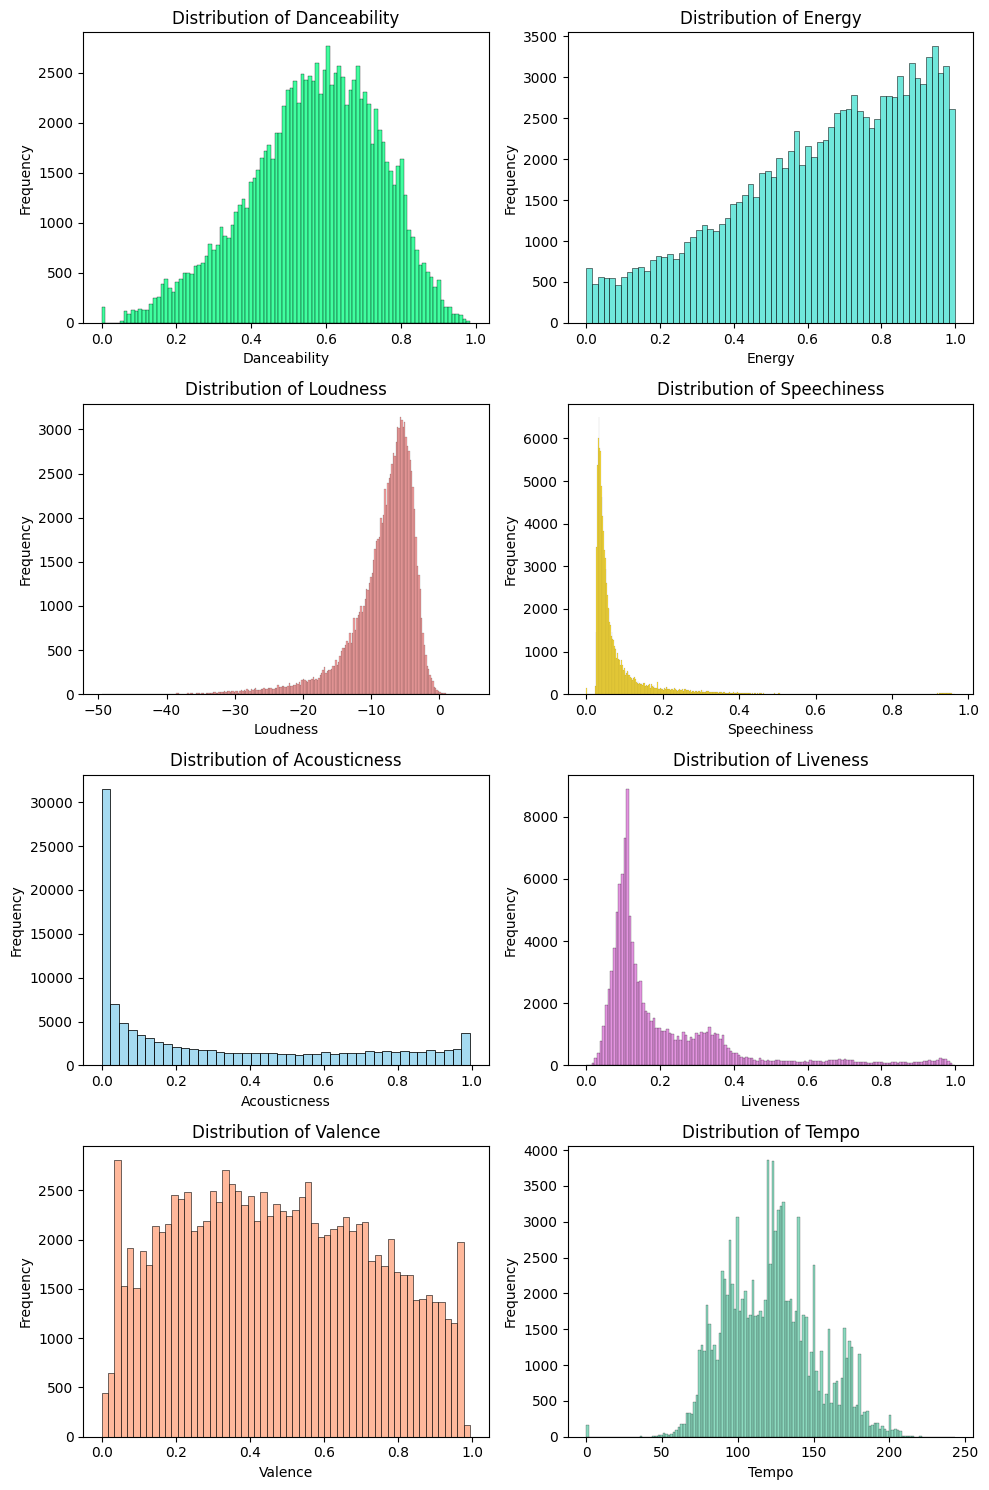

In [ ]:
# Plotting Distribution of Song Characteristics
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # 4 rows, 2 columns

axes = axes.flatten()

features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "liveness", "valence", "tempo"
]

colors = [
    "springgreen", "turquoise", "lightcoral", "gold", "skyblue", "orchid", "lightsalmon", "mediumaquamarine"
]

for i, (feature, color) in enumerate(zip(features, colors)):
    sns.histplot(data=spotify_df, x=feature, kde=False, color=color, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature.capitalize()}")
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel("Frequency")


plt.tight_layout()
plt.show()

For most of the metrics, a simple histogram suffices for an informative visualization. As we can see in most of these histograms, the distribution has a skew towards one side. This makes sense, as most songs do not differ too much, and the ones that do tend to differ in one direction.

For two columns -- duration and instrumentalness -- because of the uneven distribution and having extremely spread out data, log scales were necessary for a clearer picture.

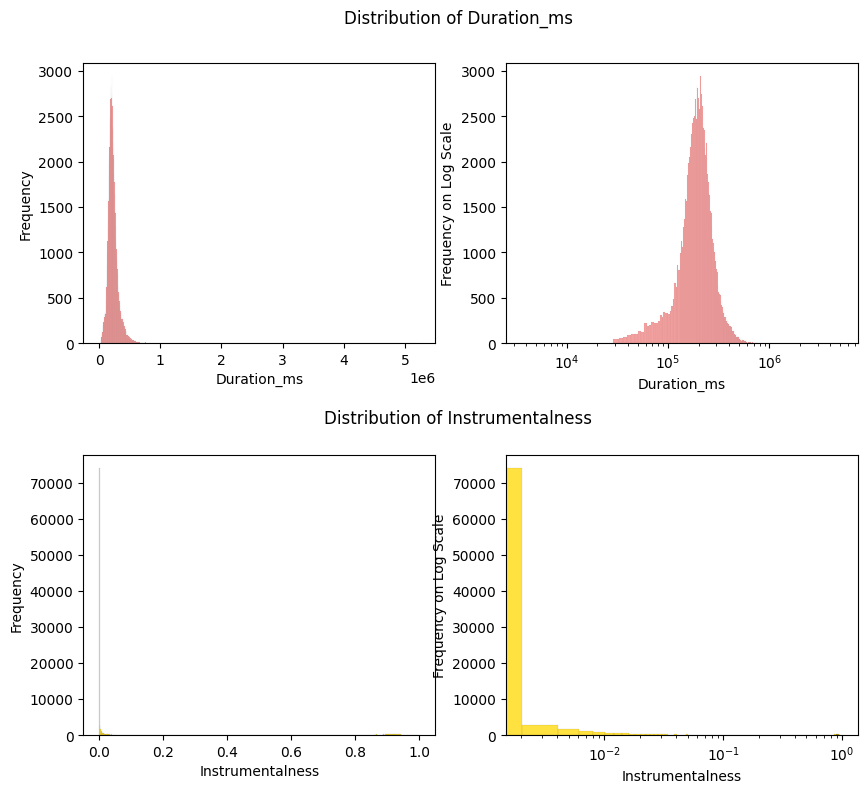

In [ ]:
# Plotting Duration/Instrumentalness Distribution after Scaling
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 Columns

axes = axes.flatten()

features = [
    "duration_ms", "instrumentalness"
]

colors = ["lightcoral", "gold"]


for i, (feature, color) in enumerate(zip(features, colors)):
    sns.histplot(data=spotify_df, x=feature, kde=False, color=color, ax=axes[2 * i])
    axes[2 * i].set_xlabel(feature.capitalize())
    axes[2 * i].set_ylabel("Frequency")

    sns.histplot(data=spotify_df, x=feature, kde=False, color=color, ax=axes[2 * i + 1])
    axes[2 * i + 1].set_xscale('log')
    axes[2 * i + 1].set_xlabel(feature.capitalize())
    axes[2 * i + 1].set_ylabel("Frequency on Log Scale")

    fig.text(0.5, 1.00 - (i * 1.0 / len(features)), f'Distribution of {feature.capitalize()}', ha='center', fontsize=12)

plt.subplots_adjust(top=0.95, hspace=0.4)
plt.show()

As we can see on the left, the distribution is not clear on the left due to the scaling of x and y axes. Thus, by applying a logarithm to the axis, it is much easier to view.

### **2.2 Frequency of Genres**

One feature that has an outsize impact on our intial table is music genre. The data provider scraped the Spotify API by genre categories. Depending on implementation issues of the scraper, the distribution of genres might not be a representative cross-section of the Spotify catalogue.

Thus, before performing any regression, it is important for us to examine the distribution of genres.

We visualize the most frequently appearing and the least frequently appearing genres. To have a clean graph with observable differences between the bars, we do a truncation. Although this might be deceptive as to scale, we consider the benefits of being able to clearly see small differences between categories to be worth it.

In [ ]:
# Genre Statistics
spotify_genre_counts = spotify_df_cleaned.copy().drop_duplicates(subset='track_id', keep="first")
spotify_genre_counts = spotify_genre_counts.groupby('track_genre').size().reset_index(name='count')
spotify_genre_counts = spotify_genre_counts.sort_values('count', ascending=False)

percentile = int(0.2 * len(spotify_genre_counts))
top_20_genres = spotify_genre_counts.head(percentile)
bot_20_genres = spotify_genre_counts.tail(percentile)
bot_20_genres = bot_20_genres.sort_values('count', ascending=True)

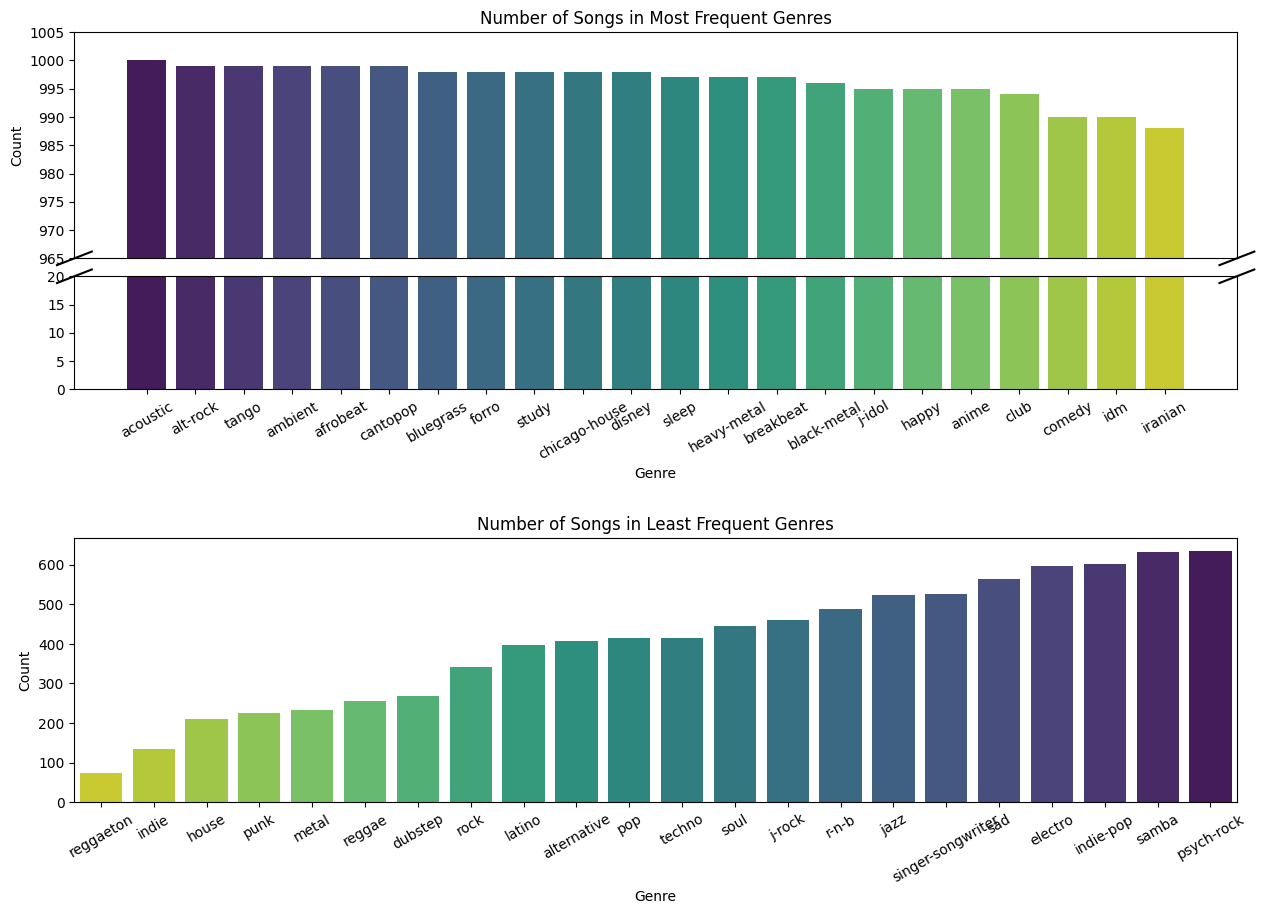

In [ ]:
# Plotting Frequent Genres
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(4, 1, height_ratios=[0.6, 0.3, 0.3, 0.7])
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
ax_lower = fig.add_subplot(gs[3])

sns.barplot(data=top_20_genres, x="track_genre", y="count", hue="track_genre", legend=False, palette="viridis", ax=ax_top)
sns.barplot(data=top_20_genres, x="track_genre", y="count", hue="track_genre", legend=False, palette="viridis", ax=ax_bottom)

ax_top.set_ylim(965, 1005)
ax_bottom.set_ylim(0, 20)

kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-0.015, 0.015), (-0.03, 0.03), **kwargs)
ax_top.plot((1 - 0.015, 1 + 0.015), (-0.03, 0.03), **kwargs)
kwargs.update(transform=ax_bottom.transAxes)
ax_bottom.plot((-0.015, 0.015), (1 - 0.06, 1 + 0.06), **kwargs)
ax_bottom.plot((1 - 0.015, 1 + 0.015), (1 - 0.06, 1 + 0.06), **kwargs)

ax_top.set_title("Number of Songs in Most Frequent Genres")
ax_top.xaxis.set_visible(False)
ax_top.set_ylabel("Count")
ax_bottom.set_xlabel("Genre")
ax_bottom.set_ylabel("")
ax_bottom.tick_params(axis='x', labelrotation=30)

sns.barplot(data=bot_20_genres, x="track_genre", y="count", hue="track_genre", legend=False, palette="viridis_r", ax=ax_lower)

ax_lower.set_title("Number of Songs in Least Frequent Genres")
ax_lower.set_xlabel("Genre")
ax_lower.set_ylabel("Count")
ax_lower.tick_params(axis='x', labelrotation=30)

plt.subplots_adjust(hspace=0.1)
plt.show()

### **2.3 Genres Sorted by Average Popularity**



We also care about genre distribution by average popularity -- since this is the key metric we are trying to regress against.

In [ ]:
# Distribution of Popular Genres
popular_genre_df = spotify_df_cleaned[["track_genre", "popularity"]].copy().groupby("track_genre").mean().reset_index()
popular_genre_df = popular_genre_df.sort_values("popularity", ascending=False).reset_index(drop=True)

percentile = int(0.2 * len(popular_genre_df))
top_20_genre_pop = popular_genre_df.head(percentile)
bot_20_genre_pop = popular_genre_df.tail(percentile)
bot_20_genre_pop = bot_20_genre_pop.sort_values("popularity", ascending=True).reset_index(drop=True)

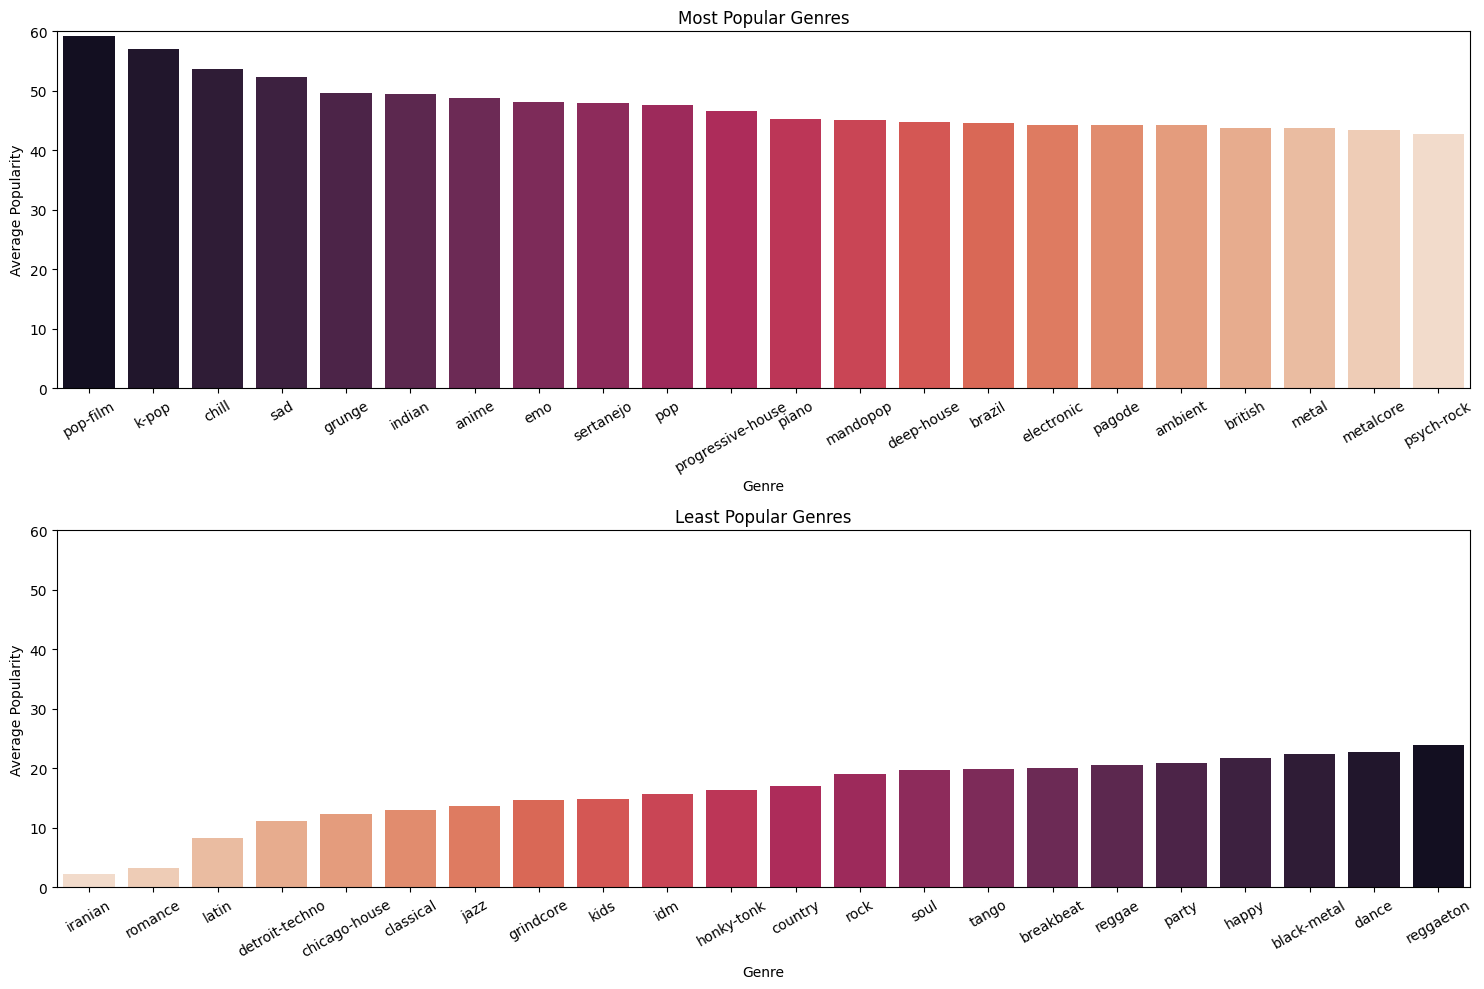

In [ ]:
# Plotting popular genres
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 1)
ax_upper = fig.add_subplot(gs[0])
ax_lower = fig.add_subplot(gs[1])

sns.barplot(data=top_20_genre_pop, x="track_genre", y="popularity", hue="track_genre", legend=False, palette="rocket", ax=ax_upper)
sns.barplot(data=bot_20_genre_pop, x="track_genre", y="popularity", hue="track_genre", legend=False, palette="rocket_r", ax=ax_lower)

ax_upper.set_ylim(0, 60)
ax_lower.set_ylim(0, 60)

ax_upper.set_title("Most Popular Genres")
ax_upper.set_xlabel("Genre")
ax_upper.set_ylabel("Average Popularity")
ax_upper.tick_params(axis='x', labelrotation=30)
ax_lower.set_title("Least Popular Genres")
ax_lower.set_xlabel("Genre")
ax_lower.set_ylabel("Average Popularity")
ax_lower.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

From our graphs, we can see that the greatest average popularity genres have an average popularity around 50+. We can also see that our least average popularity genres have an average popularity of less than 10.

### **2.4 Correlation between Track Features**

As an important check before we start modeling, we want to check correlation between track features. This helps us spot out potential problems with multicollinearity when creating more complex models. It also gives us a quick way to assess the potential in modeling various relationships.

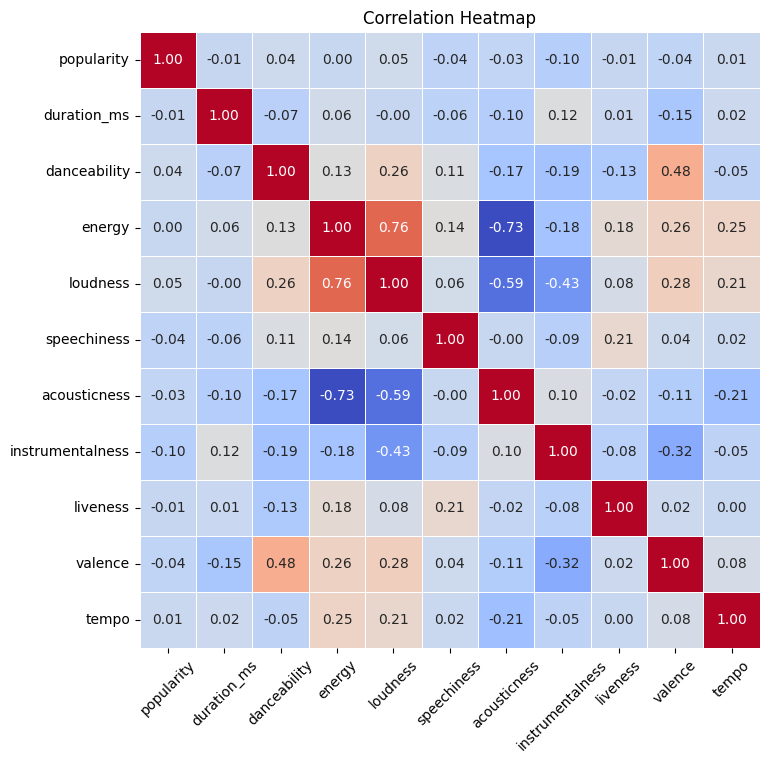

In [ ]:
# Correlation Heat Map Plot
corr_df = spotify_df_cleaned.copy().select_dtypes(include=["float64", "int64"])
corr_df = corr_df.drop(columns=["time_signature", "mode", "key"])
popularity_corr = corr_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    data=popularity_corr,
    annot=True,
    cmap="coolwarm",
    cbar=False,
    fmt=".2f",
    linewidths=0.5
)

plt.xticks(rotation=45)
plt.title("Correlation Heatmap")

plt.show()

From the correlation heatmap above, we can note that the corelation values of all the featuers relative to popularity are very low. This signifies the possibility that we need complex modeling as we need to include multiple features to discover any patterns.

### **2.5 3D-Scatterplot of Excitement-Related Characteristics**

Based on our matrix, energy, loudness, and acousticness are quite strongly correlated with each other. To better see this, we create a 3D-scatterplot, with each characteristic on one axis. As an additional feature to help with our modeling decision-making, we add a heatmap for the datapoints, with warmer colors representing higher popularity. We do this in hopes of spotting potential trends for higher popularity tracks, which we want to exploit during modeling.

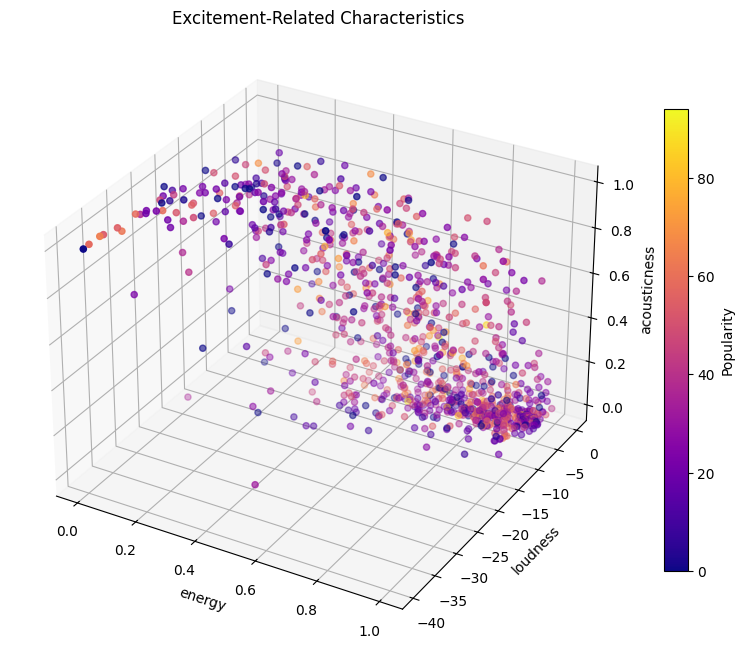

In [ ]:
# 3-D Scatterplot, Excitement-Related Characteristics
scatter_3d_df = spotify_df_cleaned.copy().drop_duplicates(subset="track_id", keep="first")
scatter_3d_df = scatter_3d_df.sample(n=1000, random_state=42).reset_index(drop=True)

energy = scatter_3d_df["energy"].to_numpy()
loudness = scatter_3d_df["loudness"].to_numpy()
acousticness = scatter_3d_df["acousticness"].to_numpy()
popularity = scatter_3d_df["popularity"].to_numpy()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
scatter = ax.scatter3D(energy, loudness, acousticness, c=popularity, cmap='plasma')
plt.colorbar(scatter, label='Popularity', shrink=0.6)

plt.title("Excitement-Related Characteristics")
ax.set_xlabel("energy")
ax.set_ylabel("loudness")
ax.set_zlabel("acousticness")

plt.tight_layout()
plt.show()

From this scatterplot, we can note that the points are grouped together. This indicates a relationship between energy, loudness, and acousticness.

### **2.6 Top Artists & Tracks, using various metrics**

This section performs EDA dedicated to spotting smaller-scale patterns that might be of interest. We rank the top artists, not just by overall popularity, but by a couple different metrics of interest

In [ ]:
unique_tracks_df = spotify_df_cleaned.copy().drop_duplicates(subset="track_id", keep="first").drop(columns=["track_id", "track_genre"])

**2.6.1 Most Popular Artists**

In [ ]:
most_popular_artists = """
SELECT artists, AVG(popularity) AS avg_popularity
FROM unique_tracks_df
GROUP BY artists
ORDER BY avg_popularity DESC
"""
most_popular_artists = duckdb.query(most_popular_artists).df()
most_popular_artists.reset_index(drop=True).head()

artists  avg_popularity
0        Sam Smith;Kim Petras           100.0
1            Bizarrap;Quevedo            99.0
2               Manuel Turizo            98.0
3  Bad Bunny;Chencho Corleone            97.0
4     Bad Bunny;Bomba Estéreo            95.0

Interestingly, the most popular "artists" are collaborations between artists. This may indicate that collarborations tend to do better, or it can also indicate that as collarborations do not occur often, this measurement is not a good indicator of popularity.

**2.6.2 Most Danceable Artists**

In [ ]:
most_danceable_artists = """
SELECT artists, AVG(danceability) AS avg_danceability
FROM unique_tracks_df
GROUP BY artists
ORDER BY avg_danceability DESC
"""
most_danceable_artists = duckdb.query(most_danceable_artists).df()
most_danceable_artists.reset_index(drop=True).head()

artists  avg_danceability
0  DJ Pierre;My Digital Enemy;Hatiras             0.979
1                     Casper & Col'ta             0.978
2               Vybz Kartel;Tommy Lee             0.975
3     Electric Slide Dance Party DJ's             0.974
4             BaianaSystem;Tropkillaz             0.974

**2.6.3 Most Popular Instrumental Tracks**

In [ ]:
most_popular_instrumental = """
SELECT artists, track_name, popularity
FROM unique_tracks_df
WHERE instrumentalness > 0.7
ORDER BY popularity DESC
"""
most_popular_instrumental = duckdb.query(most_popular_instrumental).df()
most_popular_instrumental.reset_index(drop=True).head()

artists  \
0  White Noise Baby Sleep;White Noise for Babies   
1                                       Yot Club   
2                                    Mac DeMarco   
3                                       Vundabar   
4                                  Sleep Miracle   

                                  track_name  popularity  
0  Clean White Noise - Loopable with no fade          85  
1                                     YKWIM?          84  
2                      Chamber Of Reflection          82  
3                                Alien Blues          82  
4                          Brown Sleep Noise          80

As we can see from the most popular instrumental tracks, white noise is most popular. This is probably due to the fact that people like to listen to white noise while studying, working, sleeping, etc.

**2.6.4 Valence Analysis**

Valence, as Spotify defines it, as a measurement of how happy the track makes the listener feel. A higher number indicates a higher valence. We compute the average valence for entire albums, and visualize the distribution. By visualizing this distribution, it helps us better understand one of Spotify's subjective calculations.

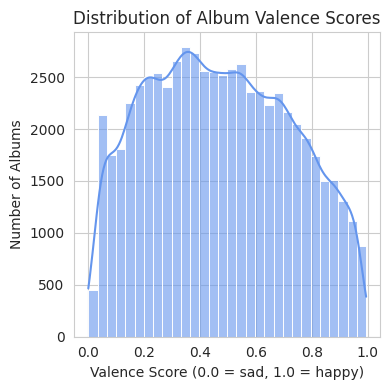

In [ ]:
happiest_albums_df = unique_tracks_df.copy()[["artists", "album_name", "valence"]].groupby(["artists", "album_name"]).mean()
sns.set_style("whitegrid")
plt.figure(figsize=(4, 4))

sns.histplot(
    data=happiest_albums_df["valence"],
    kde=True,
    color="cornflowerblue",
    alpha=0.6,
    bins=30
)

plt.title("Distribution of Album Valence Scores")
plt.xlabel("Valence Score (0.0 = sad, 1.0 = happy)")
plt.ylabel("Number of Albums")

plt.tight_layout()

In [ ]:
happiest_albums_df = """
SELECT artists, album_name, valence
FROM unique_tracks_df
ORDER BY valence DESC
"""
happiest_albums_df = duckdb.query(happiest_albums_df).df()
happiest_albums_df.reset_index(drop=True).head()

artists           album_name  valence
0                                   Victor Rice                Drink    0.995
1  Julio Preciado Y Su Banda Perla Del Pacifico  Quisiera Tener Alas    0.994
2                                    Lawineboys           Remmen Los    0.993
3                                    Debbie Doo      Roll Your Hands    0.993
4                                       Ottawan             Hands Up    0.992

In [ ]:
saddest_albums_df = """
SELECT artists, album_name, valence
FROM unique_tracks_df
ORDER BY valence ASC
"""
saddest_albums_df = duckdb.query(saddest_albums_df).df()
saddest_albums_df.reset_index(drop=True).head()

artists  \
0                             Max Richter;Lang Lang   
1  Dario Marianelli;Jack Liebeck;Benjamin Wallfisch   
2                                  Sylvain Chauveau   
3            Wolfgang Amadeus Mozart;Ingrid Haebler   
4                                      Kindy Corner   

                                       album_name  valence  
0                 Voyager - Essential Max Richter      0.0  
1  Jane Eyre - Original Motion Picture Soundtrack      0.0  
2                         Des Plumes Dans La Tête      0.0  
3              Mozart: The Complete Piano Sonatas      0.0  
4                   Sleeping Songs for New Babies      0.0

### **2.7 Understanding Abnormal Columns**

This section of our EDA is dedicated to exploring columns that are quantified and distributed in less intuitively understandable ways.

**2.7.1 Time Signature**

We group by time signature to find some general trends across various categories. Note that "0" represents a highly complex or unidentifiable time signature.

In [ ]:
def print_most_popular_by_time_signature(n):
  n_beat_df = unique_tracks_df[unique_tracks_df["time_signature"] == n].copy()
  if len(n_beat_df) == 0:
    return
  n_beat_df = n_beat_df[["artists", "track_name", "popularity"]].sort_values("popularity", ascending=False)
  info = (n_beat_df.iloc[0]["artists"], n_beat_df.iloc[0]["track_name"], n_beat_df.iloc[0]["popularity"])
  print(f"Most popular song with {i} time signature is {info[1]} by {info[0]}. It's popularity score is {info[2]}")

for i in range(6):
  info = print_most_popular_by_time_signature(i)

Most popular song with 0 time signature is Clean White Noise - Loopable with no fade by White Noise Baby Sleep;White Noise for Babies. It's popularity score is 85
Most popular song with 1 time signature is hot girl bummer by blackbear. It's popularity score is 80
Most popular song with 3 time signature is Glimpse of Us by Joji. It's popularity score is 94
Most popular song with 4 time signature is Unholy (feat. Kim Petras) by Sam Smith;Kim Petras. It's popularity score is 100
Most popular song with 5 time signature is cómo dormiste? by Rels B. It's popularity score is 89


In [ ]:
time_signature_df = unique_tracks_df.drop(columns=["artists", "album_name", "track_name", "explicit", "tempo"]).copy()
time_signature_df = time_signature_df.groupby("time_signature").agg(
    {
        "valence": "mean",
        "instrumentalness": "mean",
        "liveness": "mean",
        "time_signature": ["count"],
        "popularity": "mean"
    }
).reset_index()
time_signature_df.columns = ["time_signature", "valence", "instrumentalness", "liveness", "count", "popularity"]

Our results for time signatures mostly align with intuition.

A 4-beat time signature has the highest valence, which means it is the most likely to make people happy rather than sad. This is probably because the regularity of having 4-beats has an uplifting effect.

In [ ]:
time_signature_df.sort_values("valence", ascending=False)[["time_signature", "instrumentalness", "popularity"]].reset_index(drop=True).head(3)

time_signature  instrumentalness  popularity
0               4          0.162353   33.677646
1               5          0.258137   28.789905
2               3          0.245410   29.594950

A time signature of 0 has by far the highest instrumentalness, followed by 1 and 5. This also makes sense. Intuitively, we expect irregular time signatures to be a lot less common in songs, because the irregularity makes it less compatible with vocals. Most music featuring voice is indeed in 4 or 3-beat time signatures.

In [ ]:
time_signature_df.sort_values("instrumentalness", ascending=False)[["time_signature", "instrumentalness", "popularity"]].reset_index(drop=True).head(3)

time_signature  instrumentalness  popularity
0               0          0.641451   36.932099
1               1          0.318105   28.114657
2               5          0.258137   28.789905

We see the same rankings when it comes to liveness. This time, a reasonable, intuitive explanation would be that irregular time signatures are more common in niche, higher art genres. Niche genre are probably less likely to be recorded, and more likely to be a live performance, because of the highly specific target audience.

In [ ]:
time_signature_df.sort_values("liveness", ascending=False)[["time_signature", "liveness", "popularity"]].reset_index(drop=True).head(3)

time_signature  liveness  popularity
0               0  0.443670   36.932099
1               1  0.255728   28.114657
2               5  0.229700   28.789905

These results suggest that key contributions of time signature towards our understanding of a track has already been captured amongst the other variables. Then, we compare the average popularity across time signatures, and see very little variance. Thus, we will probably drop this feature from our final modeling.

In [ ]:
time_signature_df[["time_signature", "popularity"]].head(7)

time_signature  popularity
0               0   36.932099
1               1   28.114657
2               3   29.594950
3               4   33.677646
4               5   28.789905

**2.7.2 Multi-Genre Tracks**

One nice feature of the dataset is that it was already in 1st Normal Form. In other words, the tracks with multiple genres had been exploded, so that each genre of a track is a different row.

Here, we reverse that process. We find the tracks (using their unique track ids) that have multiple rows. Then, we collapse the rows (every feature is the same, only the genre), making genre a list of the different genres the track was classified as. We also count the number of different genres per track.

We sort our the final dataframe and present the results. The top song managed to span 9 different genres.

In [ ]:
genre_counts = spotify_df_cleaned.copy().groupby('track_id')['track_genre'].nunique()
genre_counts = genre_counts[genre_counts > 1].reset_index()
genre_counts = genre_counts.rename(columns={'track_genre': 'genre_count'})

cross_genres = spotify_df_cleaned.copy().groupby("track_id")['track_genre'].agg(lambda x: ', '.join(sorted(set(x)))).reset_index()
cross_genres = cross_genres.rename(columns={'track_genre': 'genre_list'})
track_popularities = spotify_df_cleaned.copy().groupby(["track_id", "track_name"])["popularity"].mean().reset_index()

cross_genres = cross_genres.merge(genre_counts, on='track_id').merge(track_popularities, on='track_id')
cross_genres = cross_genres.sort_values("genre_count", ascending=False)
cross_genres = cross_genres.reset_index(drop=True).drop(columns=["track_id"])
cross_genres = cross_genres[["track_name", "genre_count", "genre_list", "popularity"]]
cross_genres

track_name  genre_count  \
0              Baby Blue - Remastered 2010            9   
1                                    Layla            8   
2                                    Layla            8   
3            Keep My Name Outta Your Mouth            7   
4                       Roots Bloody Roots            7   
...                                    ...          ...   
16294        Start Me Up - Remastered 2009            2   
16295                    Astral Projection            2   
16296                       Kings of Metal            2   
16297                             Embaraço            2   
16298  Pussy Motherfuckerz - D-Fence Remix            2   

                                              genre_list  popularity  
0      blues, country, folk, j-pop, j-rock, power-pop...        67.0  
1      blues, british, country, folk, hard-rock, psyc...        74.0  
2      blues, british, country, folk, hard-rock, psyc...         0.0  
3      alt-rock, alternative, blues, garage, punk, pu...         0.0  
4      alt-rock, brazil, death-metal, groove, hard-ro...         0.0  
...                                                  ...         ...  
16294                                      british, rock         0.5  
16295                             minimal-techno, techno        47.0  
16296                                   hard-rock, metal         0.0  
16297                                   forro, sertanejo        44.0  
16298                                      happy, techno        56.0  

[16299 rows x 4 columns]

**2.7.3 Loudness**

Here, we try to get a sense of what the loudest and softest albums look like, to check if, intuitively at least, the metric lines up with our expectation.

In [ ]:
loudest_albums = """
SELECT artists, album_name, AVG(loudness), AVG(popularity) as avg_loudness
FROM unique_tracks_df
GROUP BY artists, album_name
ORDER BY avg_loudness DESC
"""
loudest_albums = duckdb.query(loudest_albums).df()
loudest_albums.reset_index(drop=True).head()

artists                             album_name  \
0        Sam Smith;Kim Petras              Unholy (feat. Kim Petras)   
1            Bizarrap;Quevedo  Quevedo: Bzrp Music Sessions, Vol. 52   
2               Manuel Turizo                             La Bachata   
3  Bad Bunny;Chencho Corleone                       Un Verano Sin Ti   
4                 Chris Brown                      Indigo (Extended)   

   avg(loudness)  avg_loudness  
0         -7.375         100.0  
1         -5.548          99.0  
2         -5.329          98.0  
3         -5.105          97.0  
4         -5.529          96.0

We do the same for the softest songs. To no surprise, 4 of the 5 softest songs were white noise sleeping tracks. One of them was a piano track.

In [ ]:
softest_albums = loudest_albums.sort_values("avg_loudness").reset_index()
softest_albums.head()

index                   artists                   album_name  \
0  62778  TNK;Jay Jones;Gundy;Wahu      Drop It Low, (Extended)   
1  57887                  J Balvin      Perreo Tenebroso Vol. 4   
2  57888    J Balvin;Maria Becerra  Feliz Cumpleaños con Perreo   
3  57889         J Balvin;Skrillex               pov: it's 2021   
4  57890        J Balvin;Bad Bunny       El perreo es el futuro   

   avg(loudness)  avg_loudness  
0         -6.992           0.0  
1         -5.969           0.0  
2         -3.956           0.0  
3         -3.142           0.0  
4         -5.795           0.0

**2.7.4 Duration**

Now, we turn our attention to duration. First, we get the longest individual tracks.

In [ ]:
longest_tracks = """
SELECT artists, track_name, duration_ms, popularity
FROM unique_tracks_df
ORDER BY duration_ms DESC
"""
longest_tracks = duckdb.query(longest_tracks).df()
longest_tracks.reset_index(drop=True).head()

artists                                  track_name  duration_ms  \
0    Tale Of Us                    Unity (Voyage Mix) Pt. 1      5237295   
1     Timo Maas      Crossing Wires 002 - Continuous DJ Mix      4789026   
2  Seth Troxler       The Lab 03 - Continuous DJ Mix Part 1      4730302   
3     Loco Dice         Amnesia Ibiza Underground 10 DJ Mix      4563897   
4   Mark Farina  House of Om - Mark Farina - Continuous Mix      4447520   

   popularity  
0          35  
1          11  
2           8  
3          17  
4          11

Then, we get the longest albums.

In [ ]:
longest_albums = """
SELECT artists, album_name, duration_ms, popularity
FROM unique_tracks_df
ORDER BY duration_ms DESC
"""
longest_albums = duckdb.query(longest_albums).df()
longest_albums.reset_index(drop=True).head()

artists                                         album_name  \
0    Tale Of Us                                 Unity (Voyage Mix)   
1     Timo Maas  Crossing Wires 002 - Compiled And Mixed By Tim...   
2  Seth Troxler                          Seth Troxler - The Lab 03   
3     Loco Dice                     Amnesia Ibiza - Underground 10   
4   Mark Farina                               House of OM (DJ Mix)   

   duration_ms  popularity  
0      5237295          35  
1      4789026          11  
2      4730302           8  
3      4563897          17  
4      4447520          11

Same for shortest tracks.

In [ ]:
shortest_tracks = longest_tracks.sort_values("duration_ms").reset_index(drop=True)
shortest_tracks.head()

artists  \
0                              Leila Bela   
1                              Leila Bela   
2          Leila Bela;Leila's Opera Class   
3  Wolfgang Amadeus Mozart;Ingrid Haebler   
4        Robert Schumann;Pavel Nersessian   

                                          track_name  duration_ms  popularity  
0                             The Exorsism Begins...         8586           0  
1                                                V-4        13386           0  
2  Screams for a Finale! (feat. Leila's Opera Class)        15800           0  
3                          Andante in C Major, K. 1a        17453           0  
4  Carnaval, Op. 9: No. 20, Pause (Live in Japan,...        17826           0

And shortest albums.

In [ ]:
shortest_albums = longest_albums.sort_values("duration_ms").reset_index(drop=True)
shortest_albums.head()

artists  \
0                              Leila Bela   
1                              Leila Bela   
2          Leila Bela;Leila's Opera Class   
3  Wolfgang Amadeus Mozart;Ingrid Haebler   
4        Robert Schumann;Pavel Nersessian   

                                          album_name  duration_ms  popularity  
0                                        Angra Manyu         8586           0  
1                                        Angra Manyu        13386           0  
2                                        Angra Manyu        15800           0  
3                 Mozart: The Complete Piano Sonatas        17453           0  
4  Schumann, Poulenc & Others: Piano Works (Live ...        17826           0

**2.7.5 Explicit v.s. Non-Explicit Songs, Staring to Feature Engineer**

We explore which genres are more or less likely to have explicit language in the music. We additionally compute the gini coefficient, to observe the purity of splits generated by categorizing the data based on clean v.s. explicit language.

Importantly, we compute the average popularity of explicit and non-explicit tracks, broken down by genre, to see how much value there is in including explicitness in our final modeling.

In [ ]:
explicit_df = spotify_df_cleaned.copy().groupby("track_genre").agg({
    "explicit": ["count", "sum"],
    "popularity": [
        # Average popularity of explicit tracks
        lambda x: x[spotify_df_cleaned["explicit"] == True].mean(),
        # Average popularity of non-explicit tracks
        lambda x: x[spotify_df_cleaned["explicit"] == False].mean()
    ]
}).reset_index()

# Flatten multi-level column names and rename them
explicit_df.columns = ["genre", "total_tracks", "explicit_tracks",
                      "explicit_popularity", "non_explicit_popularity"]

explicit_df["explicit_ratio"] = explicit_df["explicit_tracks"] / explicit_df["total_tracks"]
explicit_df["non_explicit_tracks"] = explicit_df["total_tracks"] - explicit_df["explicit_tracks"]

def calculate_gini(explicit_count, total_count):
    p = explicit_count / total_count
    return p * (1 - p)

explicit_df['gini_coefficient'] = explicit_df.apply(
    lambda x: calculate_gini(x['explicit_tracks'], x['total_tracks']), axis=1
)

explicit_df = explicit_df.sort_values("explicit_ratio").reset_index(drop=True)

In [ ]:
explicit_df = explicit_df.sort_values("explicit_ratio", ascending=False).reset_index(drop=True)
explicit_df.head()

genre  total_tracks  explicit_tracks  explicit_popularity  \
0    comedy          1000              656            25.358232   
1       emo          1000              465            53.552688   
2       sad          1000              450            52.884444   
3   j-dance          1000              391            26.092072   
4  hardcore          1000              325            42.055385   

   non_explicit_popularity  explicit_ratio  non_explicit_tracks  \
0                23.235465           0.656                  344   
1                43.413084           0.465                  535   
2                51.965455           0.450                  550   
3                27.018062           0.391                  609   
4                33.240000           0.325                  675   

   gini_coefficient  
0          0.225664  
1          0.248775  
2          0.247500  
3          0.238119  
4          0.219375

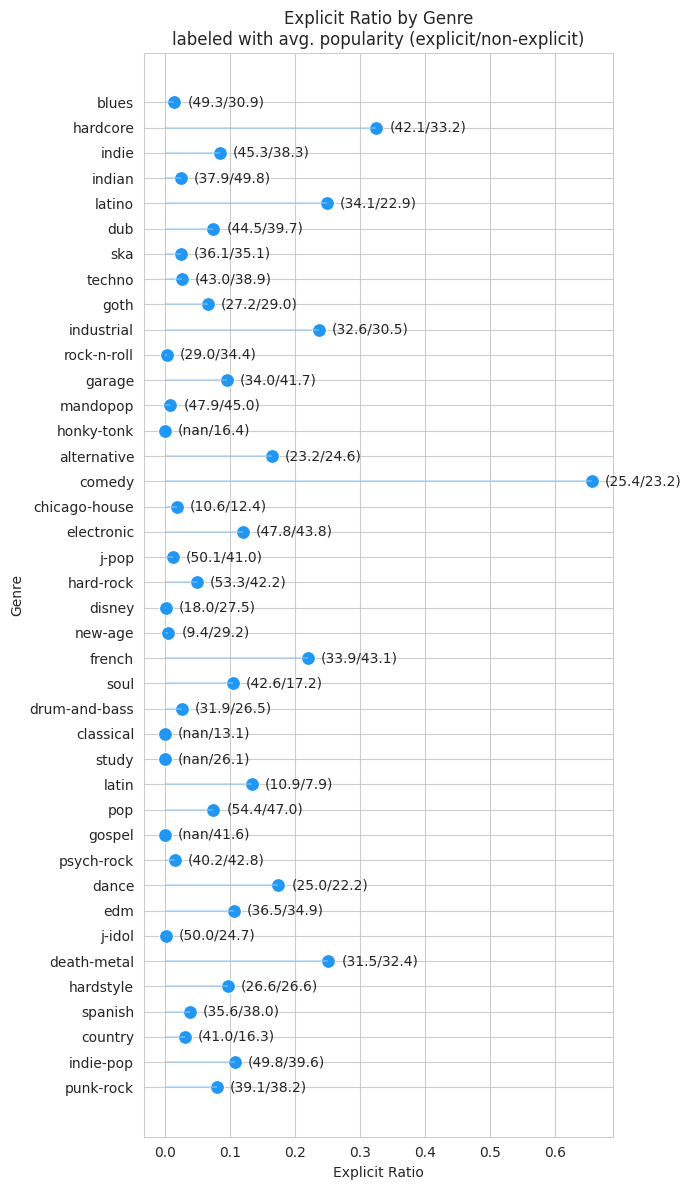

In [ ]:
# Plotting Explicit Dataframe
explicit_df = explicit_df.sample(n=40, random_state=42)
plt.figure(figsize=(7, 12))

sns.scatterplot(data=explicit_df, y='genre', x='explicit_ratio', color='#2196F3', s=100)
plt.hlines(y=explicit_df.genre, xmin=0, xmax=explicit_df["explicit_ratio"], color='#90CAF9', alpha=0.5)

plt.title("Explicit Ratio by Genre\nlabeled with avg. popularity (explicit/non-explicit)")
plt.xlabel("Explicit Ratio")
plt.ylabel("Genre")

for i, row in enumerate(explicit_df.itertuples()):
    label = f"({row.explicit_popularity:.1f}/{row.non_explicit_popularity:.1f})"
    plt.text(row.explicit_ratio + 0.02, i, label, va="center")

plt.tight_layout()

From the visualization and computations above, as well as our correlation matrix, we see that whether a track is explicit or not has little impact on anything else. We will likely drop it in our modeling.

## **Part 3: Feature Engineering**

To make the modeling and hypothesis testing process easier and more efficient, we pre-process our data. This allows us to get more specific dataframes that we can use in more specific manners.

### **3.1 Correlation Between Track Genre and Popularity**

In Section 2.4, the heat-map shows the correlation values between quantitative variables such as `energy`, `loudness`, etc. versus `popularity`. We also want to look at the correlation between our important Categorical variable, `track_genre` versus `popularity`. In order to do so, we will use a similar statistical measurement called $\eta^2$. This is also known as a correlation ratio which is a nonparametric measurement of the proportion of variance explained by the categorical variable in relation to the continuous numerical variable. This means, we are able to see how much variation in `popularity` occurs as explained by the `track_genre`.

$\eta^2$ is able to do this by checking how different the average popularity is for each genre compared to the overall average popularity.
*   If the differences between the genre averages are large, $\eta^2$ will be closer to 1, meaning the genre strongly explains the popularity.
*   If the differences are small or nonexistent, $\eta^2$ will be closer to 0, meaning genre doesn’t really matter for popularity.

In [ ]:
# eta_squared calculation function
def eta_squared(categories, values):
    overall_mean = np.mean(values)
    category_means = {category: np.mean(values[categories == category]) for category in np.unique(categories)}
    ss_between = sum(np.sum(categories == category) * (mean - overall_mean) ** 2
                     for category, mean in category_means.items())
    ss_total = np.sum((values - overall_mean) ** 2)
    return np.sqrt(ss_between / ss_total)

categories = spotify_df_cleaned['track_genre']
values = spotify_df_cleaned['popularity']
correlation = eta_squared(categories, values)
print(f"Correlation Ratio (\N{GREEK SMALL LETTER ETA}\N{SUPERSCRIPT TWO}): {correlation}")

Correlation Ratio (η²): 0.5041960848805155


### **3.2 Grouping Tracks by Genre**

As we can see from Section 3.1, the correlation ratio is not strong which means the genre does not explain the popularity. Instead of considering what characteristics contribute to the popularity within the entire dataset, we will consider characteristics within a specific genre which makes those genres' songs popular.

In [ ]:
# Top 5 Genres USA
pop_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'pop']
country_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'country']
rnbsoul_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'].isin(['r-n-b', 'soul'])].drop_duplicates(subset='track_id', keep="first")
hiphop_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'hip-hop']
dance_elec_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'].isin(['dance', 'electronic', 'electro'])].drop_duplicates(subset='track_id', keep="first")

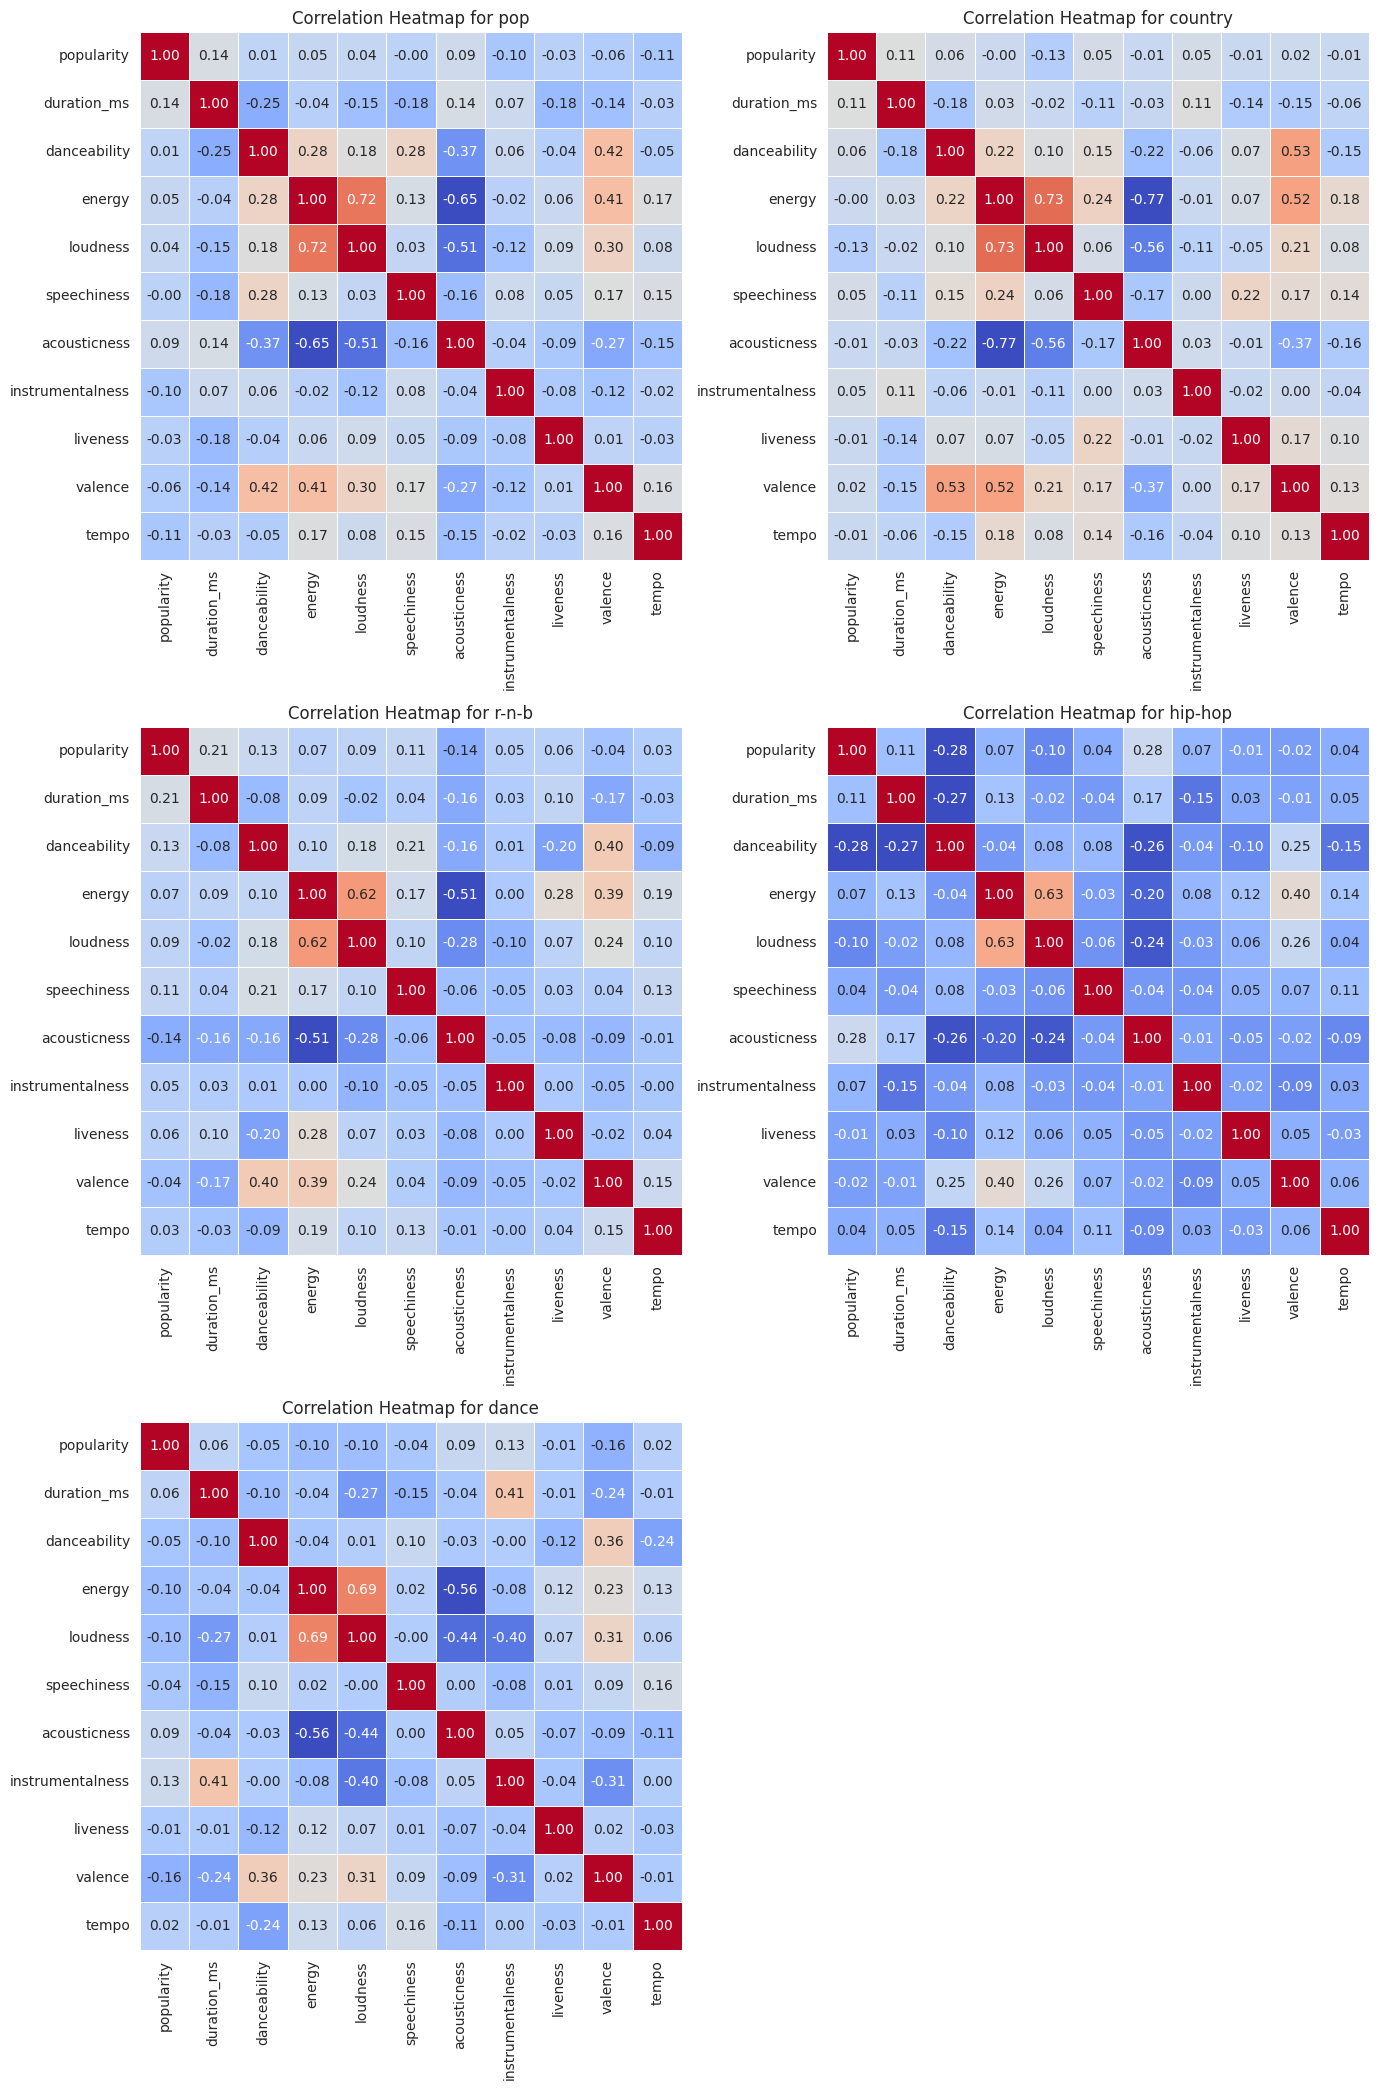

In [ ]:
# Popularity Correlations by Genre
fig, axes = plt.subplots(3, 2, figsize=(14, 21))  # 3 rows, 2 columns

for i, df in enumerate([pop_df, country_df, rnbsoul_df, hiphop_df, dance_elec_df]):
    corr_df = df.copy().select_dtypes(include=["float64", "int64"])
    corr_df = corr_df.drop(columns=["time_signature", "mode", "key"])
    popularity_corr = corr_df.corr()
    plt.subplot(3, 2, i + 1)
    sns.heatmap(
        data=popularity_corr,
        annot=True,
        cmap="coolwarm",
        cbar=False,
        fmt=".2f",
        linewidths=0.5
    )
    plt.title(f"Correlation Heatmap for {df['track_genre'].iloc[0]}")
    plt.tight_layout()
axes[2, 1].axis('off')
plt.show()

Once again, we can note that the correlation values within the genre for features versus popularity is very low. Again, this points to the idea that multiple factors are required to predict song popularity.

### **3.3 Picking Relevant Features and Scaling Data**


We begin with some feature engineering.

- We separate out the categorical features: explicit, key, mode, time_signature, and track_genre.

- These features will be passed through Label Encoders, so our models can work with it easier.

- From our preliminary analysis, we consistently see that energy and acousticness is highly correlated. We want to drop one of the two. We prefer to use energy, because it encapsulates more.

- From our preliminary analysis, we see that explicit has little impact on popularity across the board. We drop it.

- We scale the continuous variables, for more consistency.

- For duration_ms, because of our observation earlier of its abnormal distribution, we apply a logorithm.

In [ ]:
# Split continuous and categorical features
def featureEngineering(input_df):
  input_df = input_df.copy()
  X_continuous = input_df[["duration_ms", "danceability", "energy", "loudness",
                                  "speechiness", "instrumentalness", "liveness", "valence", "tempo"]]
  X_categorical = input_df[["key", "mode", "track_genre"]]
  y = input_df["popularity"]

  # Splitting Raw Data
  X_train_raw, X_test_raw, y_train, y_test = train_test_split(
      pd.concat([X_continuous, X_categorical], axis=1),
      y,
      test_size=0.2,
      random_state=42
  )

  X_train_raw = X_train_raw.reset_index(drop=True)
  X_test_raw = X_test_raw.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)
  y_test = y_test.reset_index(drop=True)

  # Split continuous and categorical features in train and test sets
  train_continuous = X_train_raw[X_continuous.columns].copy()
  train_categorical = X_train_raw[X_categorical.columns].copy()
  test_continuous = X_test_raw[X_continuous.columns].copy()
  test_categorical = X_test_raw[X_categorical.columns].copy()

  # Apply log transformation to duration_ms
  train_continuous['duration_ms'] = np.log1p(train_continuous['duration_ms'])
  test_continuous['duration_ms'] = np.log1p(test_continuous['duration_ms'])

  # Initialize and fit encoders on training data only
  encoders = {}
  X_categorical_encoded_train = pd.DataFrame()
  X_categorical_encoded_test = pd.DataFrame()

  for column in X_categorical.columns:
      encoders[column] = LabelEncoder()
      X_categorical_encoded_train[column] = encoders[column].fit_transform(train_categorical[column])
      X_categorical_encoded_test[column] = encoders[column].transform(test_categorical[column])


  # Scale continuous features
  scaler = StandardScaler()
  X_continuous_scaled_train = pd.DataFrame(
      scaler.fit_transform(train_continuous),
      columns=X_continuous.columns
  )
  # Transform on test data
  X_continuous_scaled_test = pd.DataFrame(
      scaler.transform(test_continuous),
      columns=X_continuous.columns
  )

  X_train = pd.concat([X_continuous_scaled_train, X_categorical_encoded_train], axis=1)
  X_test = pd.concat([X_continuous_scaled_test, X_categorical_encoded_test], axis=1)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = featureEngineering(spotify_df_cleaned)

After all of our processing, we visualize what the Features Dataframe looks like

In [ ]:
X_train.head()

duration_ms  danceability    energy  loudness  speechiness  \
0     1.381982      0.427460  0.950305  0.370570    -0.230378   
1     0.231844      0.583241 -1.112037 -0.285686    -0.467827   
2    -2.015748      1.264062 -1.652458 -1.635483     4.618883   
3     0.239242      0.819797  0.747647  0.486391     1.515962   
4     1.393576      1.264062  0.242990  0.302941    -0.370388   

   instrumentalness  liveness   valence     tempo  key  mode  track_genre  
0         -0.503032  2.086197 -0.196163 -0.971364   11     0           96  
1         -0.505483  0.171212 -0.161413 -1.607835    5     0           70  
2         -0.505483 -0.064882  0.711186 -0.402106    9     1           66  
3         -0.505483  1.823870  0.695742  0.528133    0     1           51  
4         -0.505483 -0.489851  0.857906 -0.603445    0     1           95

In [ ]:
# Top 5 Genres USA
pop_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'pop']
country_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'country']
rnbsoul_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'].isin(['r-n-b', 'soul'])].drop_duplicates(subset='track_id', keep="first")
hiphop_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'] == 'hip-hop']
dance_elec_df = spotify_df_cleaned[spotify_df_cleaned['track_genre'].isin(['dance', 'electronic', 'electro'])].drop_duplicates(subset='track_id', keep="first")

In [ ]:
X_train_pop, X_test_pop, y_train_pop, y_test_pop = featureEngineering(pop_df)
X_train_country, X_test_country, y_train_country, y_test_country = featureEngineering(country_df)
X_train_rnbsoul, X_test_rnbsoul, y_train_rnbsoul, y_test_rnbsoul = featureEngineering(rnbsoul_df)
X_train_hiphop, X_test_hiphop, y_train_hiphop, y_test_hiphop = featureEngineering(hiphop_df)
X_train_dance_elec, X_test_dance_elec, y_train_dance_elec, y_test_dance_elec = featureEngineering(dance_elec_df)

## **Part 4: Hypothesis Testing**

Now, we want to perform some hypothesis testing to conclude whether or not the corelation between a feature and popularity is significant. We employ the use of permutation testing.

This function performs permutation testing to assess the correlation between a feature and a target (popularity).  

In [ ]:
# Permutation Testing function to evaluate the significance of a relationship   between feature/target
def permutation_test(data, feature, target, n_permutations=1000):
    lr = LinearRegression()
    all_coefs = []
    X = data[[feature]].to_numpy()
    y = data[[target]].to_numpy()
    lr = LinearRegression()
    lr.fit(X, y)
    coef = lr.coef_[0]

    for _ in range(n_permutations):
        x = data[feature].to_numpy(copy = True)
        y = data[target].to_numpy()
        np.random.shuffle(x)
        lr.fit(x.reshape(-1, 1), y)
        all_coefs.append(lr.coef_[0])
    all_coefs = np.array(all_coefs)
    bool_array = (np.abs(all_coefs) >= abs(coef))
    p_value = sum(bool_array) / n_permutations
    return p_value

p_value = permutation_test(pop_df, "danceability", "popularity", n_permutations=1000)
print(
    "P-Value", p_value
)

P-Value 0.707


This cell runs the permutation test for multiple features within the genre dataset and stores the results, including correlations and P-values in a table.

In [ ]:
# Running permutation testing for all genres and multiple features
genre_datasets = {
    "Pop": pop_df,
    "Country": country_df,
    "RnBSoul": rnbsoul_df,
    "HipHop": hiphop_df,
    "DanceElectronic": dance_elec_df
}

results = {}

for genre, df in genre_datasets.items():
    results[genre] = {}
    for feature in ["danceability", "energy", "duration_ms", "tempo", "instrumentalness"]:
        p_value = permutation_test(df, feature, "popularity", n_permutations=1000)
        results[genre][feature] = {
            "P-Value": p_value
        }

# Display results in a pandas DataFrame
results_df = pd.DataFrame.from_dict(
    {(genre, feature): values for genre, features in results.items() for feature, values in features.items()},
    orient="index"
)
results_df.index.names = ["Genre", "Feature"]
results_df.reset_index(inplace=True)

print(results_df)

              Genre           Feature  P-Value
0               Pop      danceability    0.748
1               Pop            energy    0.149
2               Pop       duration_ms    0.000
3               Pop             tempo    0.000
4               Pop  instrumentalness    0.000
5           Country      danceability    0.082
6           Country            energy    0.920
7           Country       duration_ms    0.001
8           Country             tempo    0.874
9           Country  instrumentalness    0.082
10          RnBSoul      danceability    0.000
11          RnBSoul            energy    0.001
12          RnBSoul       duration_ms    0.000
13          RnBSoul             tempo    0.128
14          RnBSoul  instrumentalness    0.032
15           HipHop      danceability    0.000
16           HipHop            energy    0.038
17           HipHop       duration_ms    0.000
18           HipHop             tempo    0.236
19           HipHop  instrumentalness    0.017
20  DanceElec

As we can see the correlation values for each feature vs. Genre is quite low. Interestingly enough, we can see that tempo has a significantly lower p-value than the rest of the features. However, it is not less than the p-value significance threshold.

The next cell displays visualizations on the p value for features across genres using a bar plot.

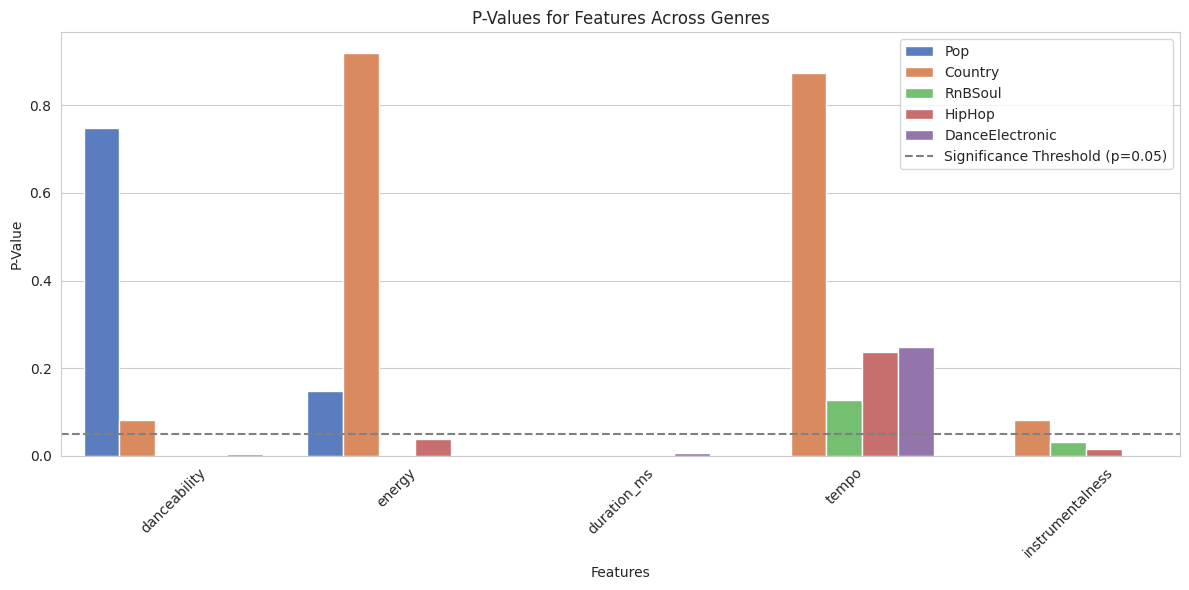

In [ ]:
# Create a bar plot
if "P-Value" not in results_df.columns:
    results_df.rename(columns={"P-value": "P-Value"}, inplace=True)


plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Feature", y="P-Value", hue="Genre", palette="muted")
plt.axhline(0.05, color="gray", linestyle="--", label="Significance Threshold (p=0.05)")
plt.title("P-Values for Features Across Genres")
plt.xlabel("Features")
plt.ylabel("P-Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **Part 5: Modeling**


Finally, we begine our Machine Learning, informed by previous EDA.

We drop the artist name, track ID, track name, and album name. We did not explore the effects of these in our earlier EDA, and we do not expect such individualized characteristics to be able to contribute significantly towards capturing a general pattern in popularity.

We create a re-usable function for simple computation and visualization of regression metrics and results.

In [ ]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))

    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)

    line = np.linspace(min(y_true), max(y_true), 100)
    plt.plot(line, line, 'r--', label='Perfect Prediction')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs True Values')
    plt.legend()

    text = f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}'
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

### **5.1 Linear Regression**


To start off, we do Linear Regression, but with different regularization optimizations. We include the following:
*    Lasso Regressor: a regression technique that uses both variable selection and regularization to prevent overfitting and enhance the accuracy of statistical models.
*    Bayesian Ridge Regressor: a regression technique that uses conditional modeling where the mean of one variable is described by a linear combination of other variables.
*    Elastic Net Regressor: a regression technique that combines the Lasso and Ridge penalties of those methods.

**5.1.1 Lasso Regressor**

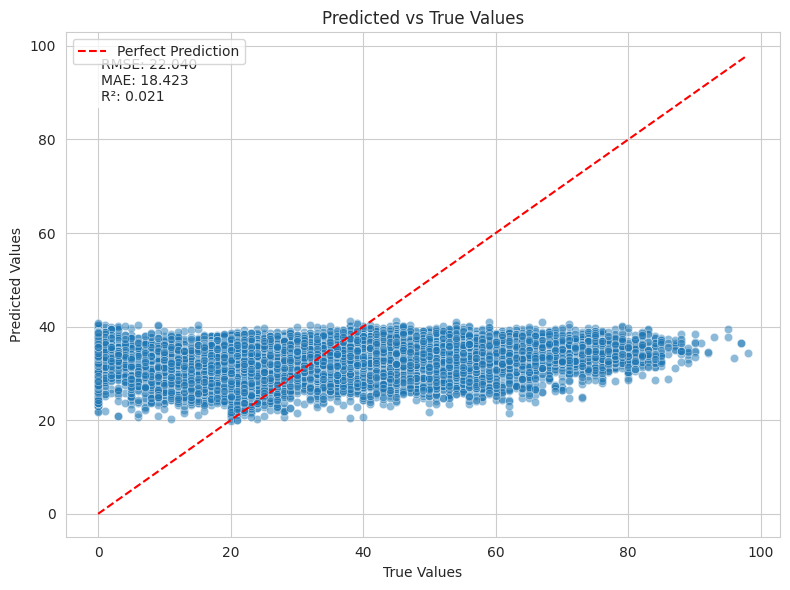

In [ ]:
lasso_model = Lasso(alpha=0.1, max_iter=500, random_state=42)
lasso_model.fit(X_train, y_train)

lasso_y_pred = lasso_model.predict(X_test)

evaluate_regression(y_test, lasso_y_pred)

**5.1.2 Bayesian Ridge Regressor**

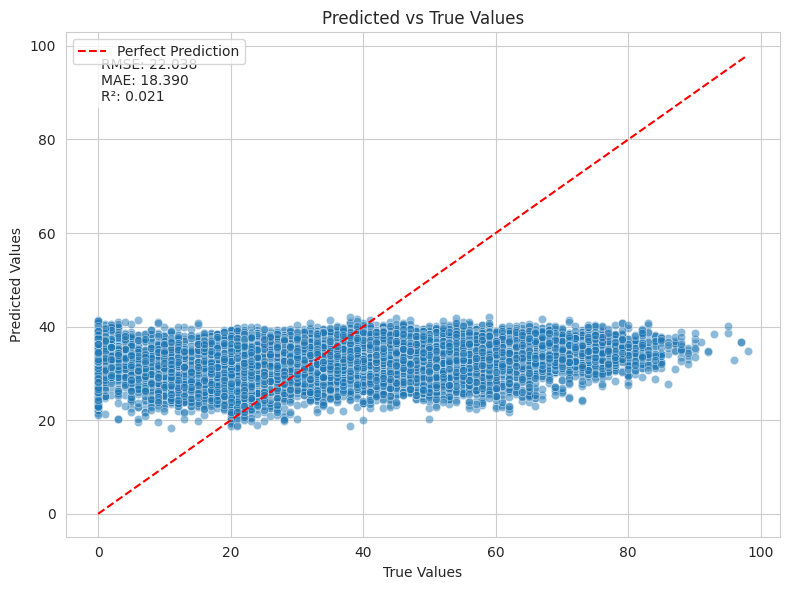

In [ ]:
br_model = BayesianRidge(max_iter=500)
br_model.fit(X_train, y_train)

br_y_pred = br_model.predict(X_test)

evaluate_regression(y_test, br_y_pred)

**5.1.3 ElasticNet Regressor**

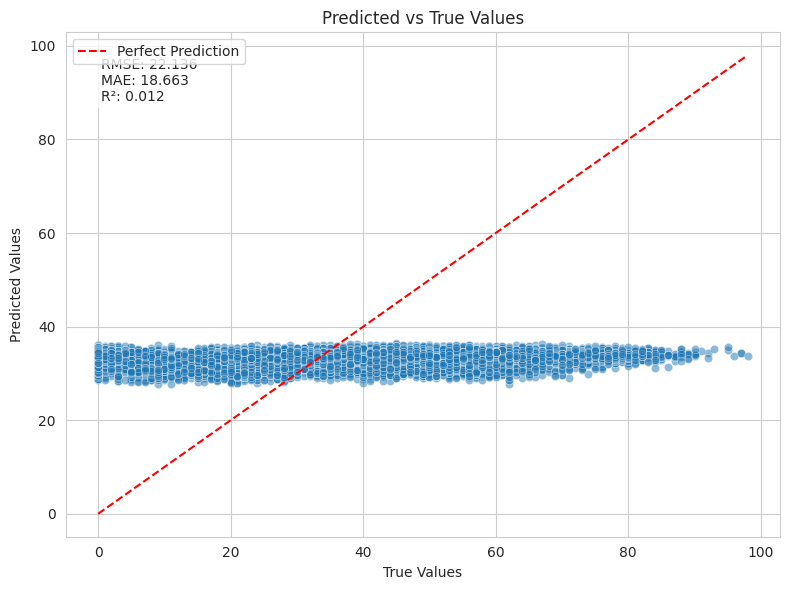

In [ ]:
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_model.fit(X_train, y_train)

elastic_y_pred = elastic_model.predict(X_test)

evaluate_regression(y_test, elastic_y_pred)

### **5.2 Decision Trees/Forests**

Since our linear models performed very poorly, we move to other architectures. We explore models based on Decision Trees. In particular, since we already know this is a difficult data set to work with, we try both bagging (Random Forest) and boosting (XG Boost) to try to achieve good performance.

**5.2.1 Random Forest**

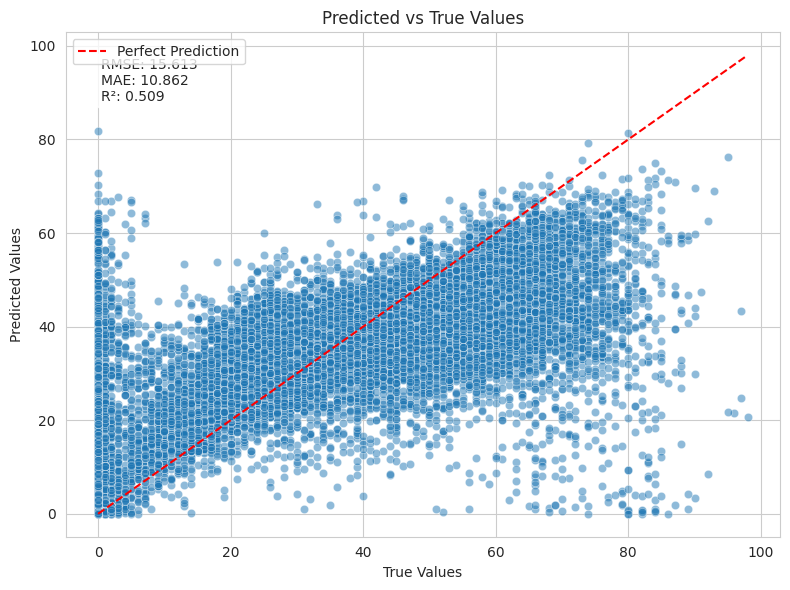

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

evaluate_regression(y_test, rf_y_pred)

Just like for linear regression, Random Forests allow us to examine feature importances, to gain further insight into what features best help us model.

In [ ]:
# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values("importance", ascending=False)

print("\nRandom Forest Feature Importance:")
rf_feature_importance.head()


Random Forest Feature Importance:


feature  importance
11   track_genre    0.221597
0    duration_ms    0.090798
1   danceability    0.089779
2         energy    0.086088
3       loudness    0.085230

**5.2.2 XGBoost**

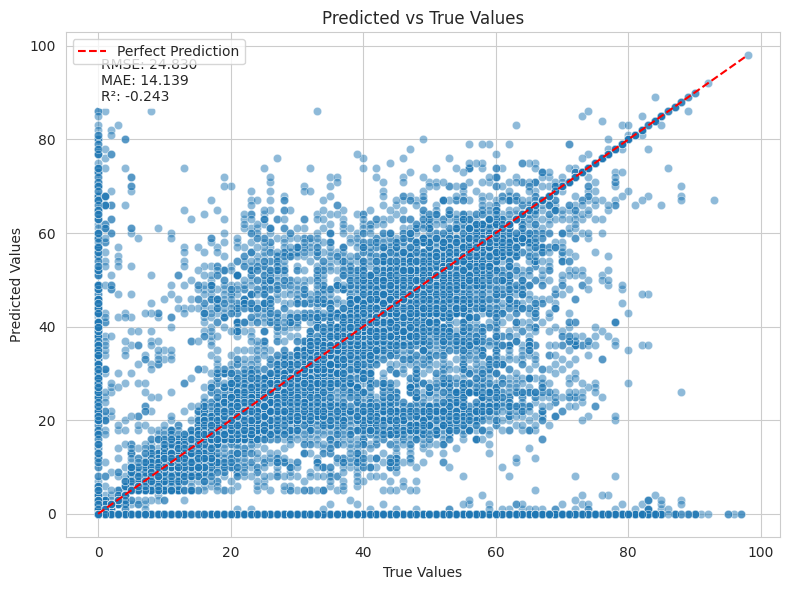

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

xgb_y_pred = xgb_model.predict(X_test)
evaluate_regression(y_test, xgb_y_pred)

Similarly, we also care about checking feature importances.

In [ ]:
# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values("importance", ascending=False)

print("\nXGB Feature Importance:")
xgb_feature_importance.head()


XGB Feature Importance:


feature  importance
11       track_genre    0.203679
5   instrumentalness    0.089132
0        duration_ms    0.078725
2             energy    0.076801
1       danceability    0.075125

**5.2.3 Randomized Search**

Since Random Forest is by far the most promising model so far, we conduct a hyperparameter search on this architecture, in an attempt to improve performance. Due to the size of our dataset, training even one model is time-consuming, let alone a hyperparameter search over the many hyperparameters that could all have a chance of helping model performance.

To try and overcome this, we use RandomizedSearchCV instead of the traditional GridSearchCV. We hope to find an equally good set of hyperparameters through the randomized selection process, whilst avoiding the cost of training many models.


Best model performance on test set:


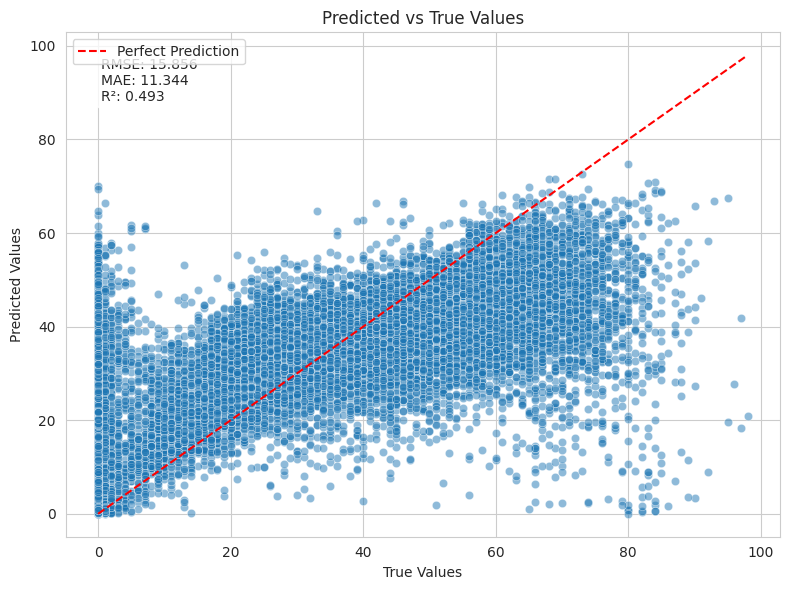

In [ ]:
param_distributions = {
    'n_estimators': np.arange(50, 150, 20),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the random forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Streamlined RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=20,
    cv=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the random search
random_search.fit(X_train, y_train)

# Use the best model for predictions
best_rf_model = random_search.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test)

# Evaluate the best model
print("\nBest model performance on test set:")
evaluate_regression(y_test, best_rf_predictions)

In [ ]:
# Feature importance of the best model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
feature_importance.head()


Feature Importance:


feature  importance
11   track_genre    0.242368
0    duration_ms    0.090223
1   danceability    0.088695
2         energy    0.085799
3       loudness    0.083950

### **5.3 Neural Network**

Beyond Decision Trees/Forests and Regression, we also considered the use of a Fully-Connected Neural Network to perform popularity predictions.

In principle, a Neural Network, although much less explainable,

The performance of such a network fell far short of Decision Trees. Even after repeated tries with different model architectures, normalizing data, and tuning hyperparameters, a Neural Network was unable to capture any meaningful pattern.

We present one of the configurations we found that ended up with the lowest Mean-Squared Error loss, implemented in Keras.

From the training output, it is clear that the gradient fails to improve with more training epochs. From the plots of the predictions, it is clear that the Network is simply resorting to guessing the mean value of the popularity distribution, with a large amount of noise.

In [ ]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.fit_transform(y_test.values.reshape(-1, 1))

model = keras.Sequential()
model.add(keras.Input(shape=(12,)))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train_scaled, epochs=20, batch_size=32)

Epoch 1/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.0306
Epoch 2/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9703
Epoch 3/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.9649
Epoch 4/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.9460
Epoch 5/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.9387
Epoch 6/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9347
Epoch 7/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9237
Epoch 8/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9270
Epoch 9/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9175
Epoch 10/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9179
Epoch 11/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.9128
Epoch 12/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9102
Epoch 13/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9136
Epoch 14/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.9100
Epoch 15/20
2850/2850 ━━━━━━━

Mean-Squared Loss (scaled by standard deviation): 0.9048410654067993


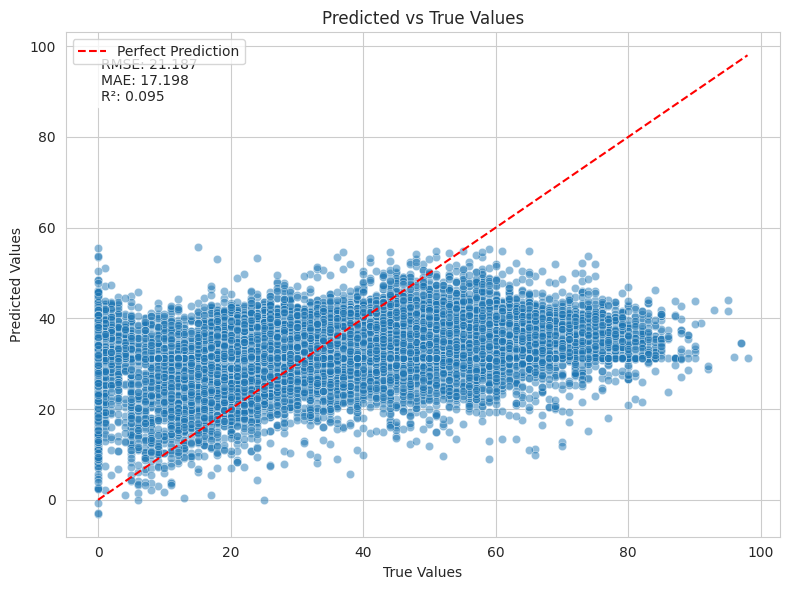

In [ ]:
evaluation = model.evaluate(X_test, y_test_scaled, verbose=0)
print(f"Mean-Squared Loss (scaled by standard deviation): {evaluation}")

prediction = model.predict(X_test, verbose=0)
nn_y_pred = y_scaler.inverse_transform(prediction).flatten()

evaluate_regression(y_test, nn_y_pred)

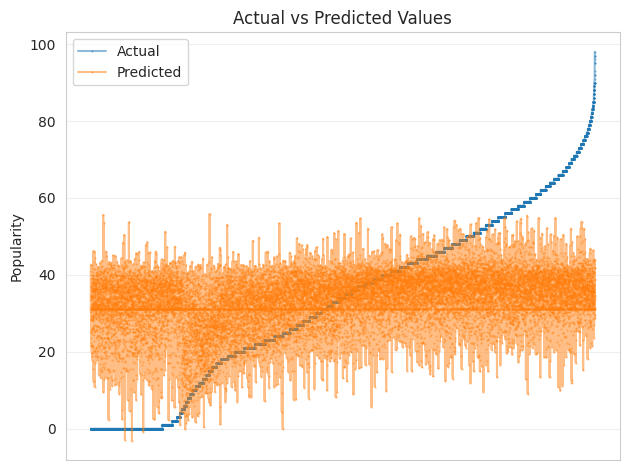

In [ ]:
all_values_df = pd.DataFrame({"y_test": y_test, "y_test_pred": nn_y_pred.flatten()})
all_values_df = all_values_df.sort_values("y_test").reset_index(drop=True)
plt.plot(all_values_df.index, all_values_df["y_test"], label='Actual', marker='.', markersize=1, alpha=0.5)
plt.plot(all_values_df.index, all_values_df["y_test_pred"], label='Predicted', marker='.', markersize=1, alpha=0.5)

plt.title(f"Actual vs Predicted Values")
plt.xticks([])
plt.ylabel("Popularity")

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

### **5.4 Genre-Specific Modeling**

Here, we explore whether modeling the popularity of tracks on a genre-specific level leads to improved predictions. We train separate models for each of the top genres identified in Section 3.2 and evaluate their performance individually.

The following function is used to evaluate model performance by calculating error for predicted vs actual values.

In [ ]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics (RMSE, MAE, R2).

    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted values

    Returns:
    - metrics: dict, containing RMSE, MAE, and R2 values
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        "rmse": np.sqrt(mse),
        "mae": mae,
        "r2": r2
    }

    return metrics

The following code trains various regression models for different music genres. It loads pre-processed training and test data, trains the models, computes the predictions, and evaluates performance.

In [ ]:
# Genre-specific modeling
genres = ["pop", "country", "rnbsoul", "hiphop", "dance_elec"]
models = {}
results = {}

for genre in genres:

    X_train = eval(f"X_train_{genre}")
    X_test = eval(f"X_test_{genre}")
    y_train = eval(f"y_train_{genre}")
    y_test = eval(f"y_test_{genre}")

    # Train Lasso Regression
    lasso_model = Lasso(alpha=0.1, max_iter=500, random_state=42)
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    lasso_metrics = calculate_regression_metrics(y_test, lasso_pred)

    # Train Bayesian Ridge Regression
    br_model = BayesianRidge()
    br_model.fit(X_train, y_train)
    br_pred = br_model.predict(X_test)
    br_metrics = calculate_regression_metrics(y_test, br_pred)

    # Train ElasticNet Regression
    elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    elastic_model.fit(X_train, y_train)
    elastic_pred = elastic_model.predict(X_test)
    elastic_metrics = calculate_regression_metrics(y_test, elastic_pred)

    # Store models and results
    models[genre] = {
        "Lasso": lasso_model,
        "Bayesian Ridge": br_model,
        "ElasticNet": elastic_model,
    }

    results[genre] = {
        "Lasso": {
            "true_values": y_test,
            "predicted_values": lasso_pred,
            **lasso_metrics,
        },
        "Bayesian Ridge": {
            "true_values": y_test,
            "predicted_values": br_pred,
            **br_metrics,
        },
        "ElasticNet": {
            "true_values": y_test,
            "predicted_values": elastic_pred,
            **elastic_metrics,
        },
    }

Scatterplots are generated to compare predicted versus true values for different genres.

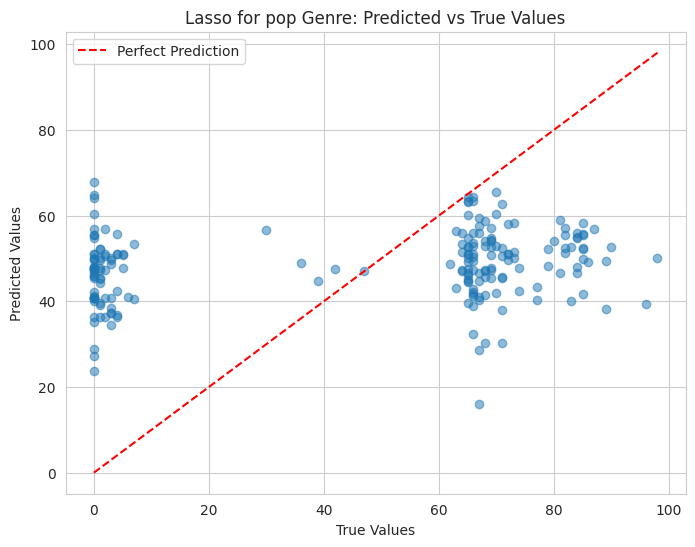

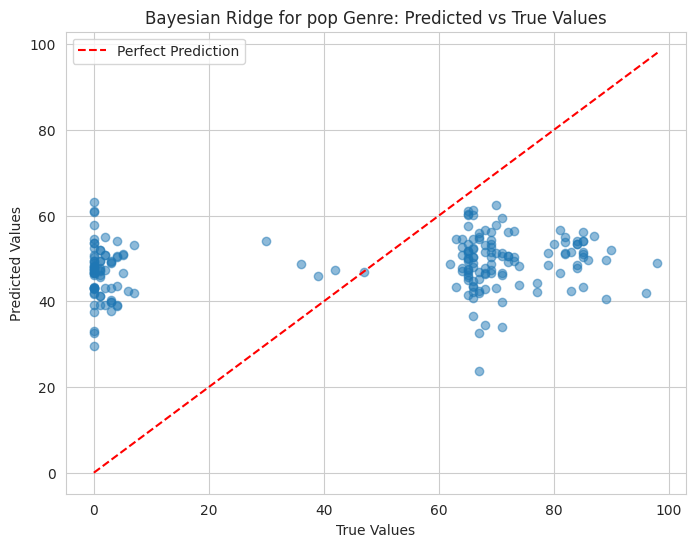

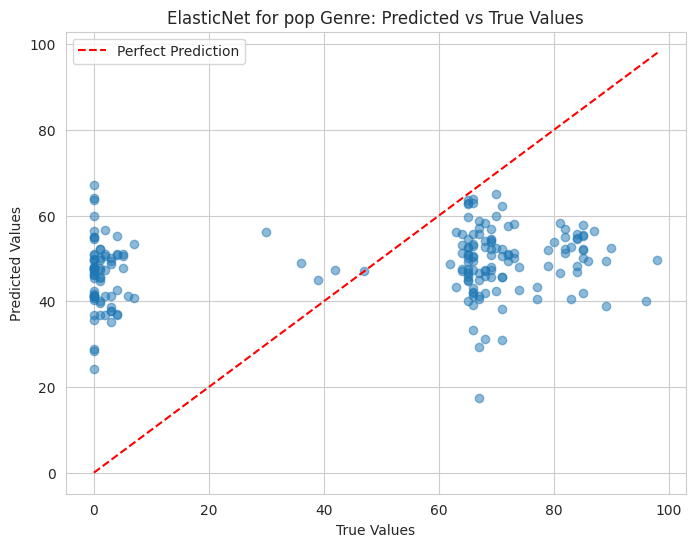

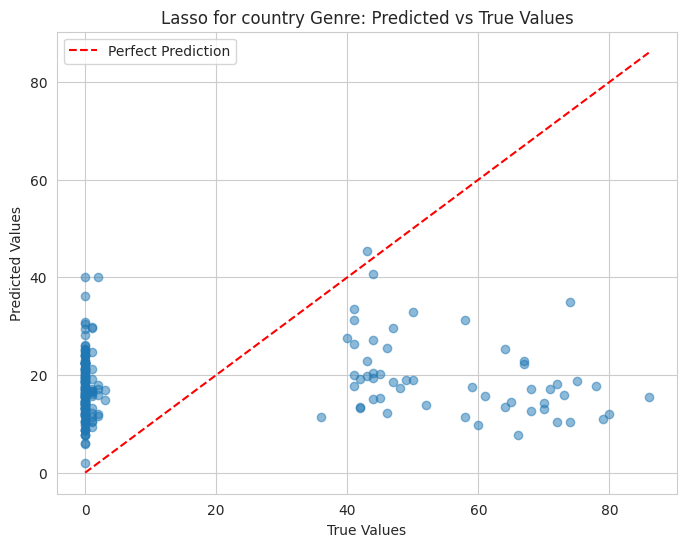

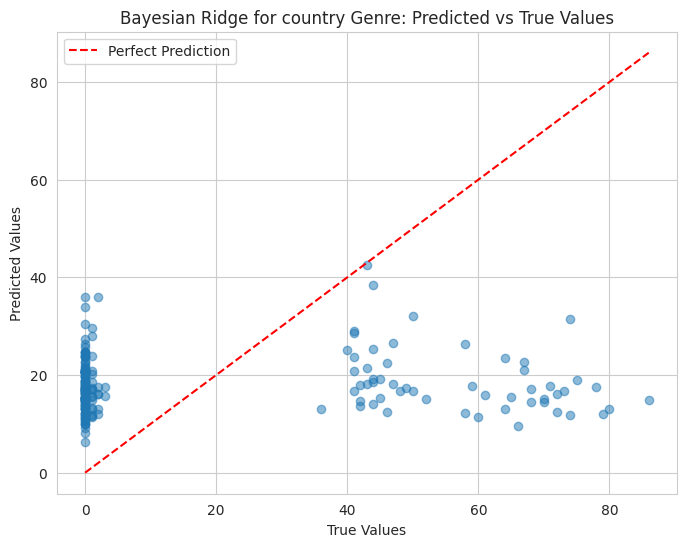

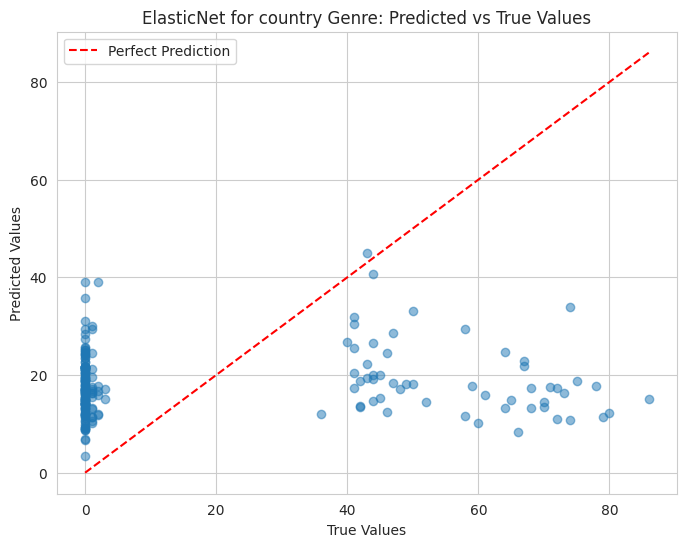

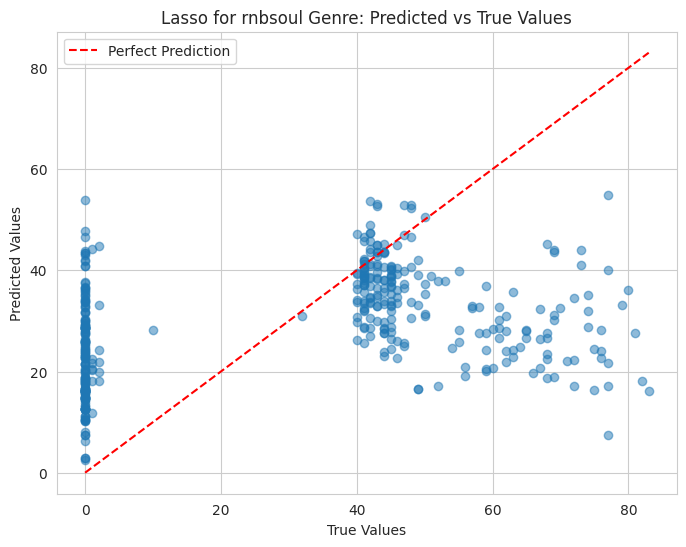

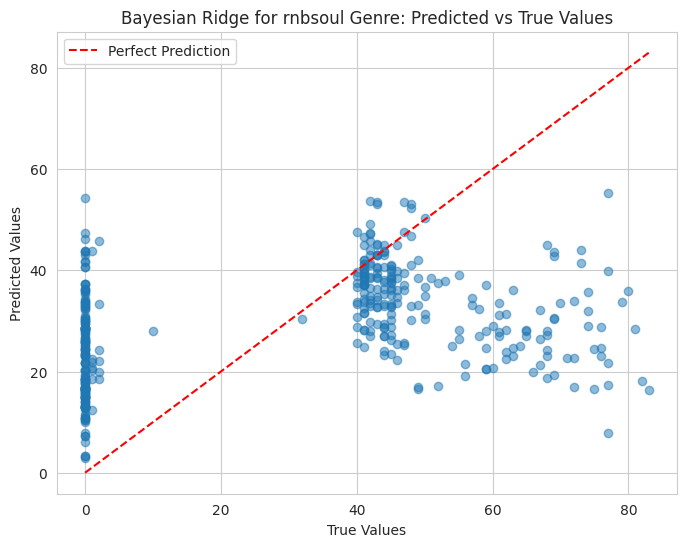

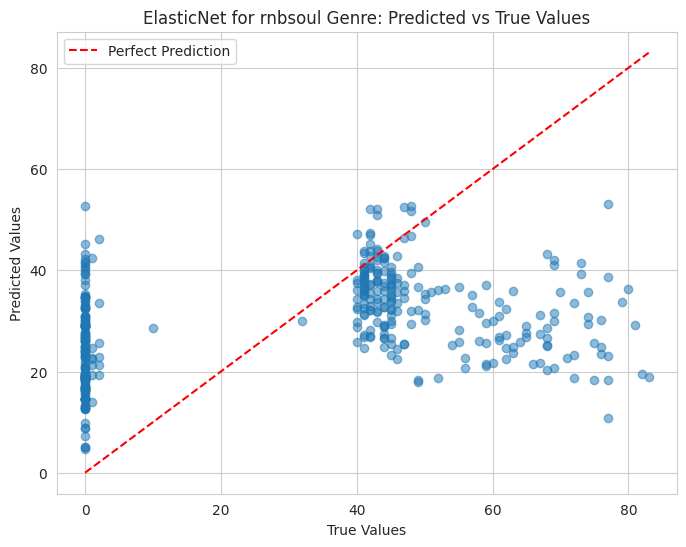

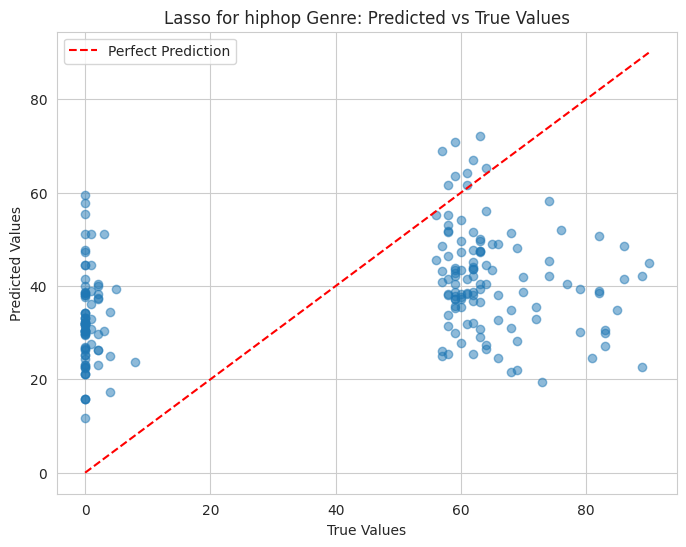

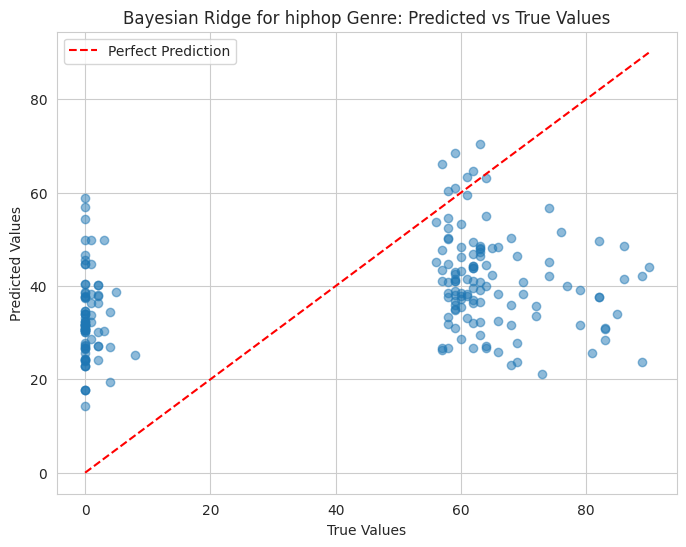

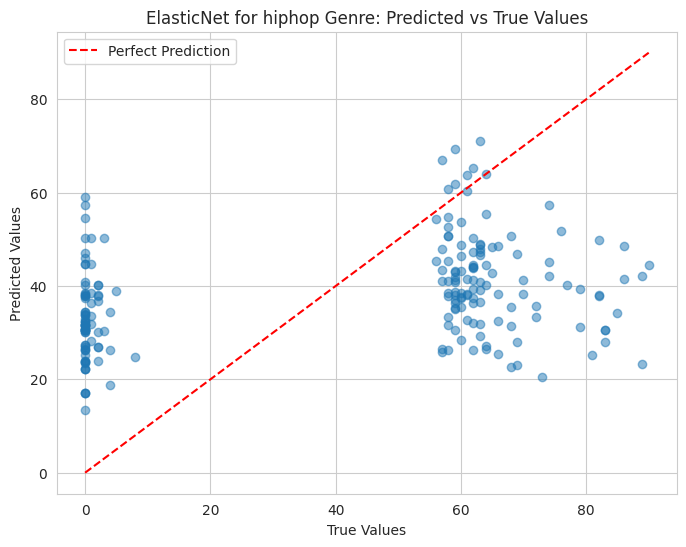

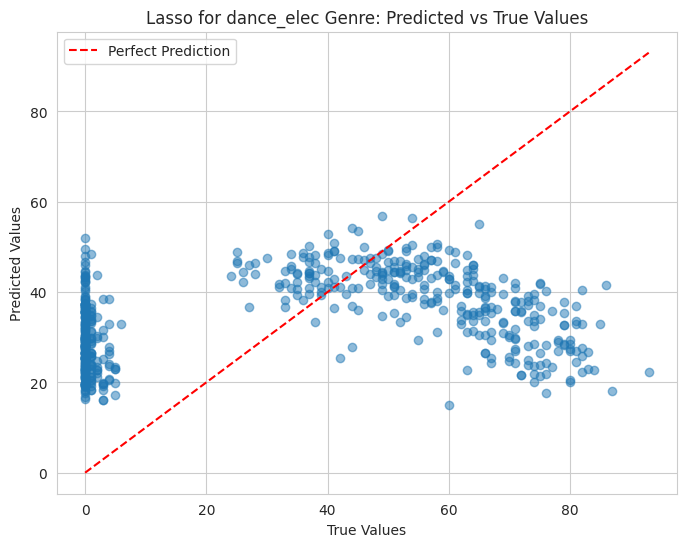

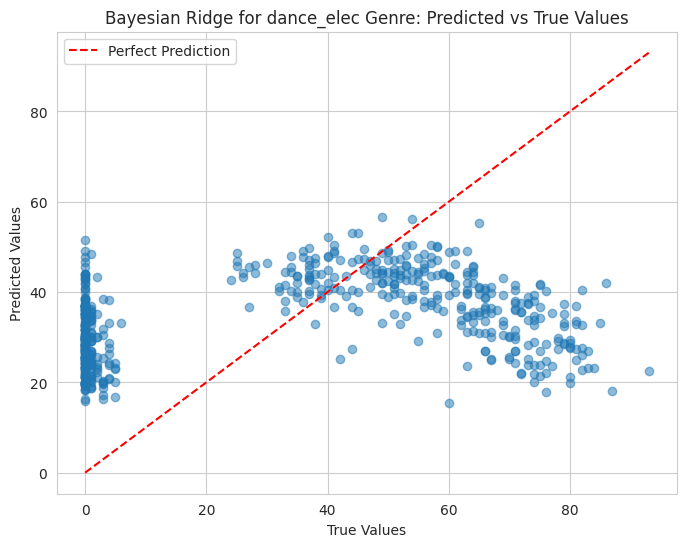

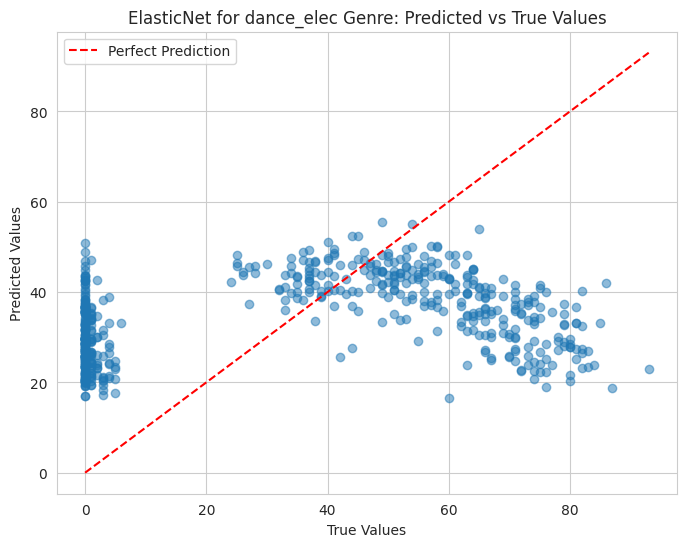

In [ ]:
# Visualizing predictions for each genre and model
for genre, metrics in results.items():
    for model_name, values in metrics.items():
        plt.figure(figsize=(8, 6))
        plt.scatter(values["true_values"], values["predicted_values"], alpha=0.5)
        plt.plot([min(values["true_values"]), max(values["true_values"])],
                 [min(values["true_values"]), max(values["true_values"])],
                 'r--', label="Perfect Prediction")
        plt.title(f"{model_name} for {genre} Genre: Predicted vs True Values")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.show()

Model performance metrics are organized in a dataframe for each genre and model.

In [ ]:
# Model Performance Metrics
summary = []

for genre, metrics in results.items():
    for model, values in metrics.items():
        summary.append({
            "Genre": genre,
            "Model": model,
            "RMSE": values.get("rmse", "N/A"),
            "MAE": values.get("mae", "N/A"),
            "R2": values.get("r2", "N/A"),
        })

summary_df = pd.DataFrame(summary)

# Display the summary DataFrame
print(summary_df)

         Genre           Model       RMSE        MAE        R2
0          pop           Lasso  34.059508  30.517688  0.031510
1          pop  Bayesian Ridge  34.036873  30.828268  0.032797
2          pop      ElasticNet  34.035720  30.562986  0.032863
3      country           Lasso  26.408000  22.510353 -0.039033
4      country  Bayesian Ridge  26.340537  22.766584 -0.033731
5      country      ElasticNet  26.387919  22.597224 -0.037453
6      rnbsoul           Lasso  24.913033  20.383123  0.146592
7      rnbsoul  Bayesian Ridge  24.911475  20.457308  0.146698
8      rnbsoul      ElasticNet  24.938272  20.893553  0.144862
9       hiphop           Lasso  30.463023  27.633151  0.119661
10      hiphop  Bayesian Ridge  30.486211  27.822403  0.118320
11      hiphop      ElasticNet  30.474039  27.751712  0.119024
12  dance_elec           Lasso  28.978374  25.281294  0.102668
13  dance_elec  Bayesian Ridge  28.996451  25.336611  0.101548
14  dance_elec      ElasticNet  29.009238  25.403791  0

The following code creates bar plots showing the weight of each feature for individual genres and models.

The magntiude indicates the strength of influence while positive and negative signs correspond to positive and negative correlations.

We first iterate through all the weights and collect them into a single dataframe, for ease of access

In [ ]:
# List of feature names from your dataset
feature_names = [
    "duration_ms", "danceability", "energy", "loudness", "speechiness", "instrumentalness", "liveness", "valence", "tempo", "key", "mode",	"track_genre"
]

feature_weights = []

for genre in genres:
    lasso_model = models[genre]["Lasso"]
    br_model = models[genre]["Bayesian Ridge"]
    elastic_model = models[genre]["ElasticNet"]

    # Extract coefficients for each model
    if lasso_model is not None:
        lasso_weights = lasso_model.coef_  # Coefficients for Lasso
        feature_weights.extend([
            {"Genre": genre, "Model": "Lasso", "Feature": feature, "Weight": weight}
            for feature, weight in zip(feature_names, lasso_weights)
        ])

    if br_model is not None:
        br_weights = br_model.coef_  # Coefficients for Bayesian Ridge
        feature_weights.extend([
            {"Genre": genre, "Model": "Bayesian Ridge", "Feature": feature, "Weight": weight}
            for feature, weight in zip(feature_names, br_weights)
        ])

    if elastic_model is not None:
        elastic_weights = elastic_model.coef_  # Coefficients for ElasticNet
        feature_weights.extend([
            {"Genre": genre, "Model": "ElasticNet", "Feature": feature, "Weight": weight}
            for feature, weight in zip(feature_names, elastic_weights)
        ])

# Convert feature weights to a DataFrame
weights_df = pd.DataFrame(feature_weights)


Then, we print out the top three weights (sorted by absolute value) for each model

In [ ]:
# Print top 3 weights for each genre and model
for genre in genres:
    print(f"\n--- {genre.capitalize()} Genre Feature Weights ---")

    # Group models to process
    models_to_process = ["Lasso", "Bayesian Ridge", "ElasticNet"]

    for model_name in models_to_process:
        print(f"\n{model_name} Model:")

        # Filter for the specific genre and model
        genre_model_weights = weights_df[(weights_df["Genre"] == genre) &
                                         (weights_df["Model"] == model_name)]

        # Sort by absolute weight in descending order and take top 3
        top_weights = genre_model_weights.reindex(
            genre_model_weights["Weight"].abs().sort_values(ascending=False).index
        ).head(3)

        # Print the top 3 weights
        for _, row in top_weights.iterrows():
            print(f"{row['Feature']}: {row['Weight']:.4f}")


--- Pop Genre Feature Weights ---

Lasso Model:
duration_ms: 5.4375
valence: -3.4530
tempo: -3.1053

Bayesian Ridge Model:
duration_ms: 4.2529
tempo: -2.5794
valence: -2.4345

ElasticNet Model:
duration_ms: 5.1924
valence: -3.2551
tempo: -3.0279

--- Country Genre Feature Weights ---

Lasso Model:
loudness: -7.1714
energy: 3.9847
duration_ms: 2.6592

Bayesian Ridge Model:
loudness: -4.8839
duration_ms: 2.4452
energy: 1.8101

ElasticNet Model:
loudness: -6.3531
energy: 3.1609
duration_ms: 2.6475

--- Rnbsoul Genre Feature Weights ---

Lasso Model:
track_genre: -15.8901
mode: -6.0254
danceability: 4.5121

Bayesian Ridge Model:
track_genre: -15.2921
mode: -5.9970
danceability: 4.5615

ElasticNet Model:
track_genre: -12.8824
mode: -4.8336
danceability: 4.2992

--- Hiphop Genre Feature Weights ---

Lasso Model:
danceability: -7.6705
mode: -7.1580
loudness: -5.3768

Bayesian Ridge Model:
danceability: -7.2843
mode: -5.6056
loudness: -4.6628

ElasticNet Model:
danceability: -7.4330
mode: -6.

Then, we do a visualizer for all of our weights

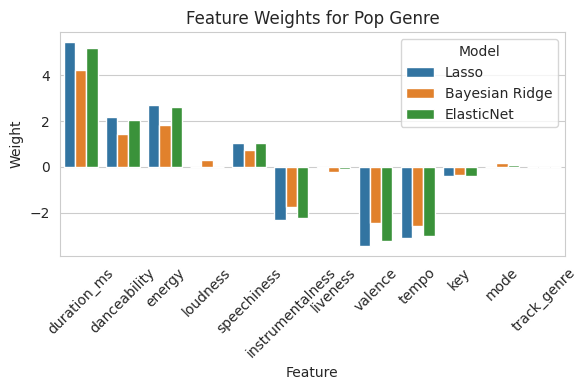

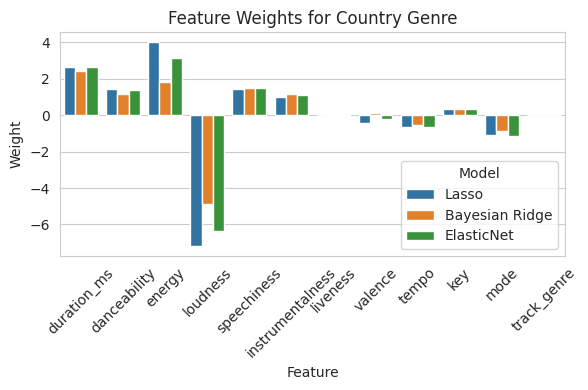

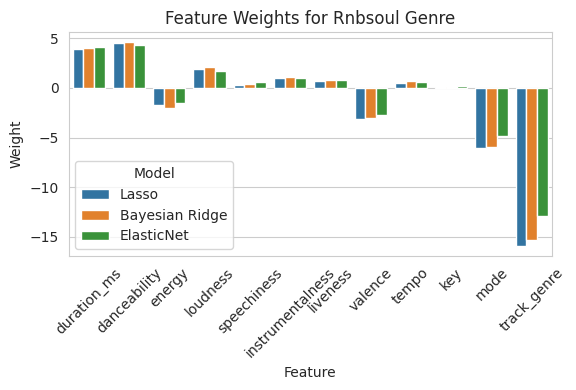

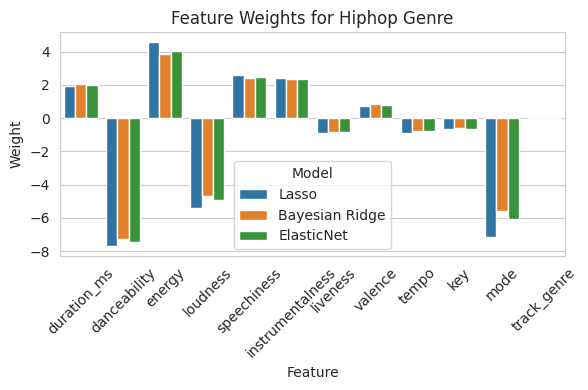

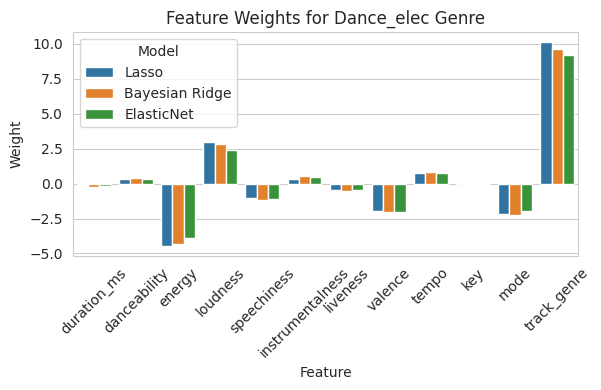

In [ ]:
for genre in genres:
    genre_weights = weights_df[weights_df["Genre"] == genre]
    plt.figure(figsize=(6, 4))
    sns.barplot(data=genre_weights, x="Feature", y="Weight", hue="Model")
    plt.title(f"Feature Weights for {genre.capitalize()} Genre")
    plt.xticks(rotation=45)
    plt.ylabel("Weight")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()

## **Part 6: Conclusion**


Our main takeaways from this project is that the popularity of songs does not depend solely on its own physical characteristics. The factors that influence popularity of songs is much more complex. Our initial belief was that the characteristics of a song was related to the popularity of the song more significantly than our results. Other factors that could have been considered when predicting song popularity are:
*   Campaigns and Advertisements
*   Social Media Popularity
*   Artist Popularity
*   Catchy Lyrics (subjective measurement)

Intuitively, we expected song characteristics to have some correlation with popularity, but our modeling failed to reflect this. Our best model, Random Forest, explained roughly half the variance in song popularity ($r^2 \sim 0.5$). Our Hypothesis Testing and Correlation Analysis also showed that our song characteristics had very little predictive power. In retrospect, we realize that music is defined to be subjective to all people. There can be different, unpredictable trends across different time periods and places.

Given our results, there are definitely other factors that we could have considered or added to our data to improve our prediction. Some things that we can consider if we were to redo this project include:
*   Combine data such as:
 *   Song marketing
 *   Yearly trends
 *   Social media trends
*   Analyze Lyrics/Meaning
*   Analyze only popular songs and find similarities

Throughout this project, some challenges that we came across were:
*    Figuring out relevant EDA
*    Feature Engineering
*    Picking models

Although we had some challenges, we were able to pull through. Working on this project was a great learning experience for us. We were able to utilize the skills we developed over the course of the semester through homeworks and apply the content that we learned in lecture. This project was a great opportunity to apply our skills from CIS5450 and make something cool!










